<center> <h1>TikTok Data Analysis</h1> </center>
<br><br>
Andrea Šipka, Social Computing Group, Institute for Informatics, University of Zurich

## Imports

In [1]:
# General data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
from wordcloud import WordCloud
from itertools import combinations
from scipy.stats import mannwhitneyu

# For text analysis
import re
import emoji
import spacy
import nltk
from nltk.corpus import stopwords
from textblob import Word

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreasipka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Parameters

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 999
pd.options.mode.chained_assignment = None
%matplotlib inline
plt.rcParams.update({'font.size': 16})
plt.style.use('bmh')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=2)

## Definitions

In [76]:
hashtags_pro_sure = ['blacklivesmattermovement', 'alllivesmatterwhenblacklivesmatter', 
                     'blacklivesmatterally', 'justiceforgeorgefloyd', 'justiceforgeorge', 'justiceforblacklives',
                     'arrestthecopswhomurderedbreonnataylor', 'acab', '1312', 'stoppolicebrutality']

hashtags_pro_prob = ['blacklivesmatter', 'blm', 'georgefloyd', 'breonnataylor', 'nojusticenopeace', 'icantbreathe']

hashtags_pro = hashtags_pro_sure + hashtags_pro_prob


hashtags_con_sure = ['alllivesmatternotjustblacklives', 'bluelivesmatter', 
                     'alllivesmattertrump2020', 'policelivesmatter', 'whitelivesmatter',
                     'defendthepolice', 'fundthepolice', 'alllivesmattertrump2020',
                     'nojobsmattertillcoplivesmatter']

hashtags_con_prob = ['alllivesmatter', 'backtheblue', 'notallcopsarebad']

hashtags_con = hashtags_con_sure + hashtags_con_prob


hashtags_boost = ['fyp', 'foryou', 'foryoupage', 'viral', 'xyzbca', 'fypシ', 
                 'fy', 'foryourpage', 'trending', 'tiktok', '4u']

original_sound_dict = ['original sound', 'sonido original', 'Originalton', 'Original Sound', 
                       'оригинальный звук', 'son original', 'som original', 'suono originale']

## Functions

In [77]:
# Given a list of hashtags, what is the leaning of that hashtag wrt BLM?
def hash_to_leaning(hashtags):
    leaning = 0
    
    for hashtag in hashtags:
        if hashtag in hashtags_pro_sure:
            leaning += 1
        elif hashtag in hashtags_pro_prob:
            leaning += 0.5
        elif hashtag in hashtags_con_sure:
            leaning -= 1
        elif hashtag in hashtags_con:
            leaning -= 0.5
        
    return leaning


# get info about music track
def parse_music(s):
    music_list = s['music'][1:-1].split(', ')
    
    for item in music_list:
        if 'id' in item[:item.find(':')]:
            s['music_id'] = item[item.find('\'id\': \'')+len('\'id\': \'') : -1]
        if 'title' in item[:item.find(':')]:
            s['music_title'] = item[item.find('\'title\': \'')+len('\'title\': \'') : -1]
        if 'authorName' in item[:item.find(':')]:
            s['music_author'] = item[item.find('\'authorName\': \'')+len('\'authorName\': \'') : -1]
        if 'original' in item[:item.find(':')]:
            s['music_original'] = item[item.find('\'original\': \'')+len('\'original\': \'') : ]   
            
    return s


# extract hashtags used
def parse_hashtags(s):
    hashtag_list_of_lists = s['hashtags'][2:-2].split('}, {')
    
    reslist = []
    
    for hashtag_list in hashtag_list_of_lists:
        for item in hashtag_list.split(', '):
            if 'title' in item[:item.find(':')]:
                reslist.append(item[item.find('\'title\': \'')+len('\'title\': \'') : -1])
                
    if 'duet' in reslist:
        s['duet_used'] = True
        
    s['nr_hashtags'] = len(reslist)
    s['hashtags_used'] = ', '.join(reslist)
    
    return s


# extract tagged users
def parse_extras(s):
    extras_list_of_lists = s['extras'][2:-2].split('}, {')
    
    tagged_users = []
    reslist = []
    
    for extras_list in extras_list_of_lists:
        for item in extras_list.split(', '):
            if 'userId' in item[:item.find(':')]:
                if len(item) > 12:
                    tagged_users.append(extras_list)
    
    for tagged_user in tagged_users:
        for item in tagged_user.split(', '):
            if 'userId' in item[:item.find(':')]:
                reslist.append(item[item.find('\'userId\': \'')+len('\'userId\': \'') : -1])
    
    s['nr_tags'] = len(reslist)
    s['tagged_users'] = ', '.join(reslist)
    s['leaning'] = hash_to_leaning(s['hashtags_used'].split(', '))
    
    return s

# function that calls all of the other functions
def parse_table(df, hashtagname):
    df['music_id'] = ''
    df['music_title'] = ''
    df['music_author'] = ''
    df['music_original'] = ''
    df['hashtags_used'] = ''
    df['nr_hashtags'] = 0
    df['duet_used'] = False
    df['tagged_users'] = ''
    df['nr_tags'] = 0
    df['leaning'] = ''

    df = df.apply(parse_music, axis=1)
    df = df.apply(parse_hashtags, axis=1)
    df = df.apply(parse_extras, axis=1)
    
    #delete unnecessay things
    del df['hashtags']
    del df['extras']
    del df['music']
    del df['authorstats_hearts']
    del df['challenges_desc']
    del df['challenges_id']
    del df['challenges_title']
    del df['textExtra_awemeId']
    del df['textExtra_userId']
    del df['textExtra_userUniqueId']
    del df['privateItem']
    del df['raw']
    
    df['obtained_via'] = hashtagname
    df['rank'] = df.index

    return df

def parse_raw(s):
    
    # ITEM INFO
    for item in ''.join( c for c in s['itemInfos'] if  c not in '\{\}' ).split(', '):
        if '\'id\'' in item[:item.find(':')]:
            s['video_id'] = item[item.find('\'id\': \'')+len('\'id\': \'') : -1]
        if '\'text\'' in item[:item.find(':')]:
            s['video_desc'] = item[item.find('\'text\': \'')+len('\'text\': \'') : -1]
        if '\'createTime\'' in item[:item.find(':')]:
            s['video_time'] = item[item.find('\'createTime\': \'')+len('\'createTime\': \'') : -1]
        if '\'stitchEnabled\'' in item[:item.find(':')]:
            s['stitchEnabled'] = item[item.find('\'stitchEnabled\': \'')+len('\'stitchEnabled\': \'') : ]
        if '\'shareEnabled\'' in item[:item.find(':')]:
            s['shareEnabled'] = item[item.find('\'shareEnabled\': \'')+len('\'shareEnabled\': \'') : ]
        if '\'isAd\'' in item[:item.find(':')]:
            s['isAd'] = item[item.find('\'isAd\': \'')+len('\'isAd\': \'') : ]
        if '\'diggCount\'' in item[:item.find(':')]:
            s['stats_likes'] = item[item.find('\'diggCount\': \'')+len('\'diggCount\': \'') : -1]
        if '\'shareCount\'' in item[:item.find(':')]:
            s['stats_shares'] = item[item.find('\'shareCount\': \'')+len('\'shareCount\': \'') : -1]
        if '\'commentCount\'' in item[:item.find(':')]:
            s['stats_comments'] = item[item.find('\'commentCount\': \'')+len('\'commentCount\': \'') : -1]
        if '\'playCount\'' in item[:item.find(':')]:
            s['stats_plays'] = item[item.find('\'playCount\': \'')+len('\'playCount\': \'') : -1]
        if '\'duration\'' in item[:item.find(':')]:
            s['video_length'] = item[item.find('\'duration\': \'')+len('\'duration\': \'') : -1]

        
    # AUTHOR INFO
    for item in ''.join( c for c in s['authorInfos'] if  c not in '\{\}' ).split(', '):
        if '\'userId\'' in item[:item.find(':')]:
            s['user_id'] = item[item.find('\'userId\': \'')+len('\'userId\': \'') : -1]
        if '\'uniqueId\'' in item[:item.find(':')]:
            s['user_name'] = item[item.find('\'uniqueId\': \'')+len('\'uniqueId\': \'') : -1]
        if '\'signature\'' in item[:item.find(':')]:
            s['user_signature'] = item[item.find('\'signature\': \'')+len('\'signature\': \'') : -1]
        if '\'verified\'' in item[:item.find(':')]:
            s['user_verified'] = item[item.find('\'verified\': \'')+len('\'verified\': \'') : ]
            
    # MUSIC INFO
    for item in ''.join( c for c in s['musicInfos'] if  c not in '\{\}' ).split(', '):
        if '\'musicId\'' in item[:item.find(':')]:
            s['music_id'] = item[item.find('\'musicId\': \'')+len('\'musicId\': \'') : -1]
        if '\'musicName\'' in item[:item.find(':')]:
            s['music_title'] = item[item.find('\'musicName\': \'')+len('\'musicName\': \'') : -1]
        if '\'authorName\'' in item[:item.find(':')]:
            s['music_author'] = item[item.find('\'authorName\': \'')+len('\'authorName\': \'') : -1]
        if '\'original\'' in item[:item.find(':')]:
            s['music_original'] = item[item.find('\'original\': \'')+len('\'original\': \'') : ]
            
    # STATS INFO
    for item in ''.join( c for c in s['authorStats'] if  c not in '\{\}' ).split(', '):
        if '\'followingCount\'' in item[:item.find(':')]:
            s['authorstats_following'] = item[item.find('\'followingCount\': \'')+len('\'followingCount\': \'') : -1]
        if '\'followerCount\'' in item[:item.find(':')]:
            s['authorstats_followers'] = item[item.find('\'followerCount\': \'')+len('\'followerCount\': \'') : -1]
        if '\'heartCount\'' in item[:item.find(':')]:
            s['authorstats_heart'] = item[item.find('\'heartCount\': \'')+len('\'heartCount\': \'') : -1]
        if '\'videoCount\'' in item[:item.find(':')]:
            s['authorstats_videos'] = item[item.find('\'videoCount\': \'')+len('\'videoCount\': \'') : -1]
        if '\'diggCount\'' in item[:item.find(':')]:
            s['authorstats_diggs'] = item[item.find('\'diggCount\': \'')+len('\'diggCount\': \'') : -1]
    
    s['hashtags'] = s['textExtra']        
    
    return s

# extract extra information (hashtags and tags) from raw data
def parse_extras_raw(s):
    hashtag_list_of_lists = s['hashtags'][2:-2].split('}, {')
    
    reslist = []
    tagged_users = []
    
    for hashtag_list in hashtag_list_of_lists:
        for item in hashtag_list.split(', '):
            if 'HashtagName' in item[:item.find(':')]:
                if len(item[item.find('\'HashtagName\': \'')+len('\'HashtagName\': \'') : -1]) > 1:
                    reslist.append(item[item.find('\'HashtagName\': \'')+len('\'HashtagName\': \'') : -1])
                    
            if 'UserId' in item[:item.find(':')]:
                if len(item) > 12:
                    tagged_users.append(item[item.find('\'UserId\': \'')+len('\'UserId\': \'') : -1])
    
    if len(s['stickerTextList']) > 2:
        item = s['stickerTextList'][2:-2]
        s['stickerText'] = item[item.find('stickerText')+len('stickerText    ') : -1] 
    
    if 'duet' in reslist:
        s['duet_used'] = True
        
    s['nr_hashtags'] = len(reslist)
    s['hashtags_used'] = ', '.join(reslist)
    
    s['nr_tags'] = len(tagged_users)
    s['tagged_users'] = ', '.join(tagged_users)
    
    s['video_link'] = 'https://www.tiktok.com/@{}/video/{}?lang=en'.format(s['user_name'], s['video_id'])       

    s['leaning'] = hash_to_leaning(s['hashtags_used'].split(', '))
    
    return s


def parse_table_raw(df, soundname):
    
    new_cols = ['itemInfos', 'authorInfos', 'musicInfos', 'challengeInfoList', 'duetInfo', 
            'textExtra', 'authorStats', 'stickerTextList', 'video_id', 'video_desc', 
            'video_time', 'stitchEnabled', 'shareEnabled', 
            'isAd', 'stats_likes', 'stats_shares', 'stats_comments', 'stats_plays', 
            'video_length', 'user_id', 'user_name', 'user_signature', 
            'user_verified', 'music_id', 'music_title', 'music_author', 'music_original', 
            'authorstats_following', 'authorstats_followers', 'authorstats_heart', 
            'authorstats_videos', 'authorstats_diggs', 'hashtags', 'extras', 
            'nr_hashtags', 'hashtags_used', 'nr_tags', 'tagged_users', 'stickerText', 
            'video_link', 'leaning']                                                              

    df = df.reindex(columns=new_cols, fill_value='')
    
    df['duet_used'] = False

    df = df.apply(parse_raw, axis=1)
        
    df = df.apply(parse_extras_raw, axis=1)

    df['rank'] = df.index
    df['obtained_via'] = soundname
        
    del df['itemInfos']
    del df['authorInfos']
    del df['musicInfos']
    del df['challengeInfoList']
    del df['textExtra']
    del df['authorStats']
    del df['stickerTextList']
    del df['extras']
    del df['hashtags']
    
    return df

def make_hashtag_dataframe(df):
        
    list_to_save = []
    
    for index, row in df.iterrows():
        for hashtag in row['hashtags_used'].split(', '):
            list_to_save.append([row['user_id'], row['video_id'], hashtag])
            
    return pd.DataFrame(list_to_save, columns=['user_id', 'video_id', 'hashtag'])

In [51]:
# List of emoji that aren't unicode, but typed
symbol_emoji = ["<3", ":)", ":-)", ":(", ":-(", ":/", ";)", ":~0", ";(", ":]", ":))", "=\\", "</3", ":D", 
                ":o)", ":*", "(:", ":O", ": (", ";-)", ":|", '":"-("', "★", '":"("', "-_-", "[:", "=)"]


# Functions to extract various metrics from status
def avg_word(txt_in):
    words = txt_in.split()
    return (sum(len(word) for word in words)/len(words))

def do_counts(data_in):
    # Get word count for each status
    data_in['word_count'] = data_in['video_desc'].apply(lambda x: len(str(x).split(" ")))
    # Get character count for each status
    data_in['character_count'] = data_in['video_desc'].str.len()
    # Calculate eaverage word length for each status
    data_in['avg_word_length'] = data_in['video_desc'].apply(lambda x: avg_word(x))
    # Get number of stop words used
    stop = stopwords.words('english')
    data_in['stopwords'] = data_in['video_desc'].apply(lambda x: len([x for x in x.split() if x in stop]))
    # Get number of words in all caps
    data_in['upper'] = data_in['video_desc'].apply(lambda x: len([x for x in x.split() if x.isupper() and len(x)>1]))

# Text cleaning function
def clean_text(s):
    
    # remove duet with
    if 'duet with @' in s['video_desc']:
        clean = s['video_desc']
        clean = s['video_desc'][s['video_desc'].find('duet with ') + len('duet with ') : ]
        clean = clean[clean.find(' ') : ]
        # split text into words
        wordlist = clean.split()
    else:
        # split text into words
        wordlist = s['video_desc'].split()
    
    # stopword dictionary
    stops = stopwords.words('english') 
    # placeholder variables
    newlist = []
    emo = 0
    
    # Function to count and remove Emojis, hashtags and URLs
    for word in wordlist:
        # detect emoji
        if word[0] in emoji.UNICODE_EMOJI:
            # second for loop necessary as emojis without space are not recognised as multiple
            for char in word:
                if char in emoji.UNICODE_EMOJI:
                    emo +=1
        # detect non-unicode emoji
        elif any(x in word for x in symbol_emoji): 
            emo +=1
            newlist.append(word)
        # add an actual word into the list 
        else:
            newlist.append(word)

            
    # need to join and resplit as previous division was only doing spaces and 
    # sometimes people don't put space after punctuation
    wordlist = re.split('\W+|_', ' '.join(newlist))
            
    # For non empty statuses, do cleaning up
    if isinstance(wordlist, list):
        # We only want to keep letters, no numbers or punctuation
        wordlist = [re.sub(r'[^a-zA-Z\s]', u'', word, flags=re.UNICODE) for word in wordlist]
        # Remove empty members of the list
        wordlist = list(filter(None, wordlist))
        # Convert everything to lower case
        wordlist = [word.lower() for word in wordlist]
        
    # Save edited words to status_cleaned column
    s['video_desc_cleaned'] = ' '.join(wordlist)
        
    # For non empty statuses, get rid of stop words, short words, and lemmatize
    if isinstance(wordlist, list):
        # Get rid of stopwords
        wordlist = [word for word in wordlist if word not in stops]
        # Don't keep words shorter than 2 letters in length
        wordlist = [word for word in wordlist if len(word)>1]
        # Lemmatize words
        wordlist = [Word(word).lemmatize() for word in wordlist]
        
    # put results into dataframe we passed in
    s['video_desc_nostop'] = ' '.join(wordlist) 
    s['num_emoji'] = emo
    
    return s

## Parsing files from hashtag

In [5]:
df_dict = {}

# Parsing all sound files
for file in os.listdir('/Users/andreasipka/Desktop/TikTok/data/hashtag'):
    if file.endswith('_videos.csv'):
        print(file)
        df_dict[file[:-11]] = pd.read_csv('data/hashtag/'+file)
        df_dict[file[:-11]] = parse_table(df_dict[file[:-11]], file[:-11])
        
# Merge what we have
all_hashtag = pd.concat(df_dict.values())


blacklivesmattermovement_videos.csv
alllivesmatterwhenblacklivesmatter_videos.csv
blacklivesmatter_videos.csv
bluelivesmatter_videos.csv
whitelivesmatter_videos.csv
blacklivesmatterally_videos.csv
alllivesmattertrump2020_videos.csv
alllivesmatternotjustblacklives_videos.csv
blm_videos.csv
georgefloyd_videos.csv
justiceforgeorgefloyd_videos.csv
backtheblue_videos.csv
policelivesmatter_videos.csv
breonnataylor_videos.csv
alllivesmatter_videos.csv


In [6]:
all_hashtag.shape

(25694, 34)

### What are the numbers we are working with here?

In [7]:
print('Number of unique pro videos: ', len(all_hashtag[all_hashtag.leaning > 0].video_id.unique()))
print('Number of unique con videos: ', len(all_hashtag[all_hashtag.leaning < 0].video_id.unique()))
print('Number of unique unclassified videos: ', len(all_hashtag[all_hashtag.leaning == 0].video_id.unique()))
print('Total unique videos: ', len(all_hashtag.video_id.unique()))
print('Total unique users: ', len(all_hashtag.user_id.unique()))
print('Total videos with duet hashtag: ', all_hashtag[all_hashtag.duet_used].shape[0])
print('Total videos with a tagged used: ', all_hashtag[all_hashtag.nr_tags > 0].shape[0])
print('My best approximation for actual number of duets: ', all_hashtag[(all_hashtag.nr_tags > 0) & 
                                                                       (all_hashtag.duet_used)].shape[0])

Number of unique pro videos:  12441
Number of unique con videos:  9752
Number of unique unclassified videos:  838
Total unique videos:  23031
Total unique users:  14419
Total videos with duet hashtag:  1964
Total videos with a tagged used:  4795
My best approximation for actual number of duets:  1753


<center> <h2>Exploring Hashtags</h2> </center>

### Pro Videos

In [8]:
pro_hashtag_df = make_hashtag_dataframe(all_hashtag[all_hashtag.leaning > 0])

### How many unique hashtags are used by pro BLM users?

In [9]:
print('Number of unique hashtags used by "pro BLM" users: ', len(pro_hashtag_df.hashtag.unique()))

Number of unique hashtags used by "pro BLM" users:  9522


### What are the most frequent hashtags connected to pro BLM hashtags?

/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0, flags=flags)


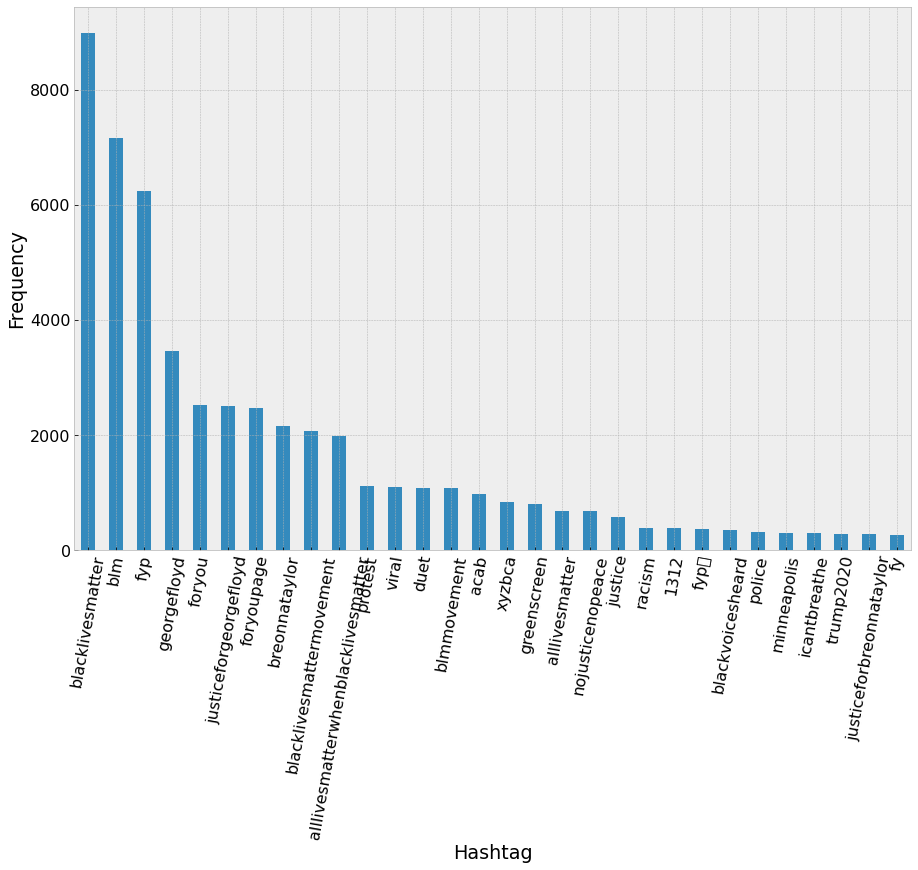

In [112]:
plt.figure(figsize=(15,10))
pro_hashtag_df['hashtag'].value_counts().head(30).plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.show()

### Hashtags related to pro BLM videos

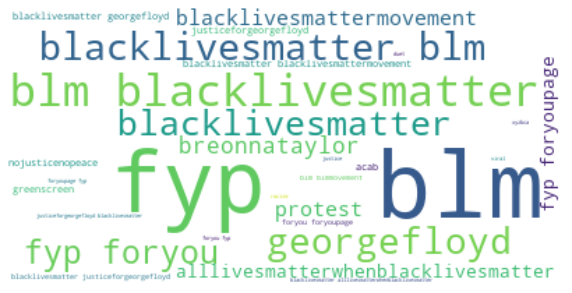

In [111]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(pro_hashtag_df['hashtag']))
wordcloud.to_file("img/proBLMhashtags_all.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Hashtags related to pro BLM videos, with seed hashtags removed

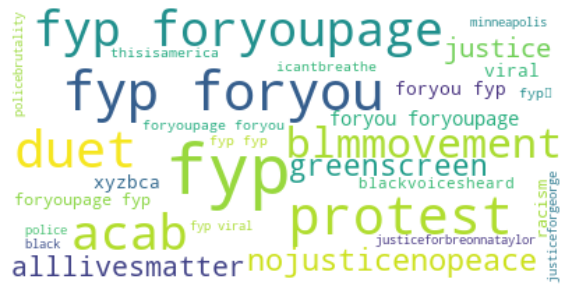

In [12]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(pro_hashtag_df[~pro_hashtag_df.hashtag.isin(hashtags_pro)].hashtag))
wordcloud.to_file("img/proBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Con Videos

In [13]:
con_hashtag_df = make_hashtag_dataframe(all_hashtag[all_hashtag.leaning < 0])

In [14]:
print('Number of unique hashtags used by "con BLM" users: ', len(con_hashtag_df.hashtag.unique()))

Number of unique hashtags used by "con BLM" users:  8987


### What are the most frequent hashtags connected to con BLM hashtags?


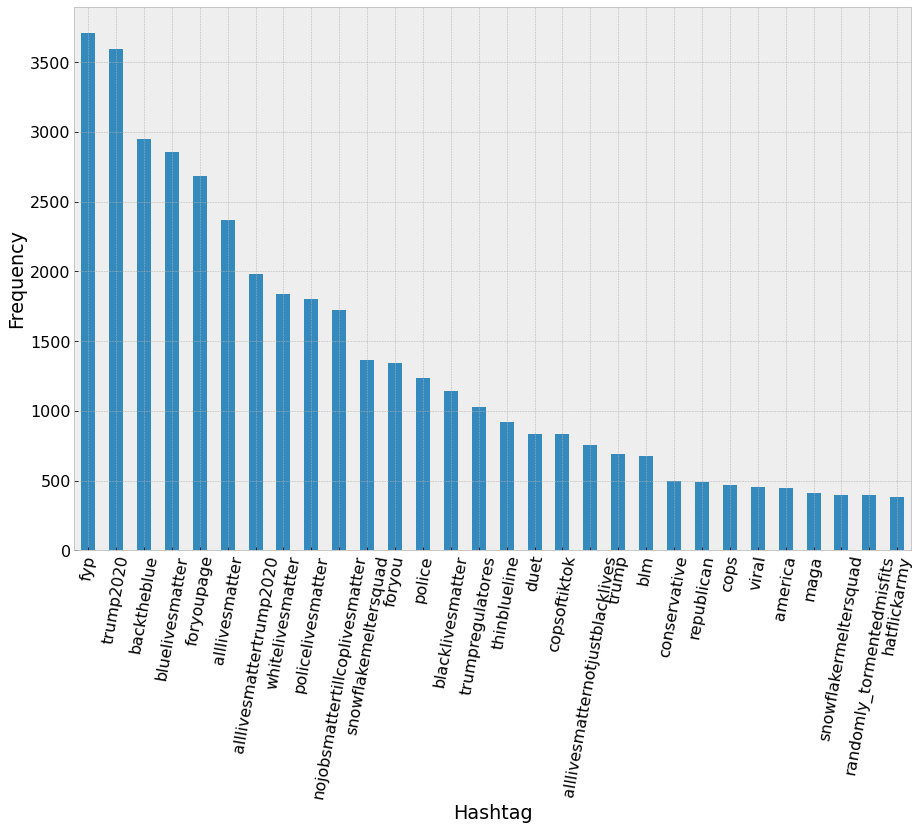

In [110]:
plt.figure(figsize=(15,10))
con_hashtag_df['hashtag'].value_counts().head(30).plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.show()

### Hashtags related to con BLM videos

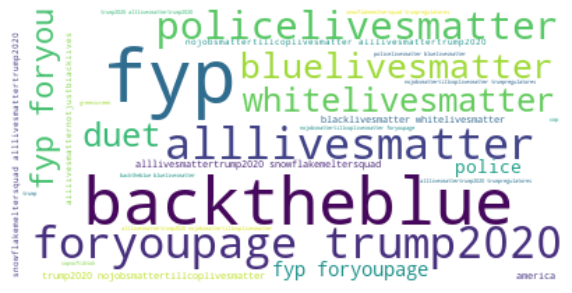

In [16]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(con_hashtag_df.hashtag))
wordcloud.to_file("img/conBLMhashtags_all.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Hashtags related to con BLM videos, with seed hashtags removed

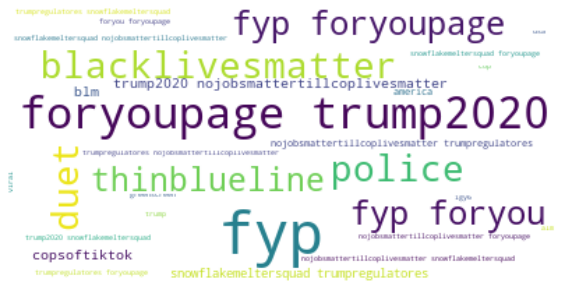

In [24]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(con_hashtag_df[~con_hashtag_df.hashtag.isin(hashtags_con)].hashtag))
wordcloud.to_file("img/conBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### unclassified (mid) videos

In [18]:
mid_hashtag_df = make_hashtag_dataframe(all_hashtag[all_hashtag.leaning == 0])

In [19]:
print('Number of unique hashtags used by unclassified users: ', len(mid_hashtag_df.hashtag.unique()))

Number of unique hashtags used by unclassified users:  1597


### What are the most frequent hashtags connected to unclassified hashtags?

/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0, flags=flags)


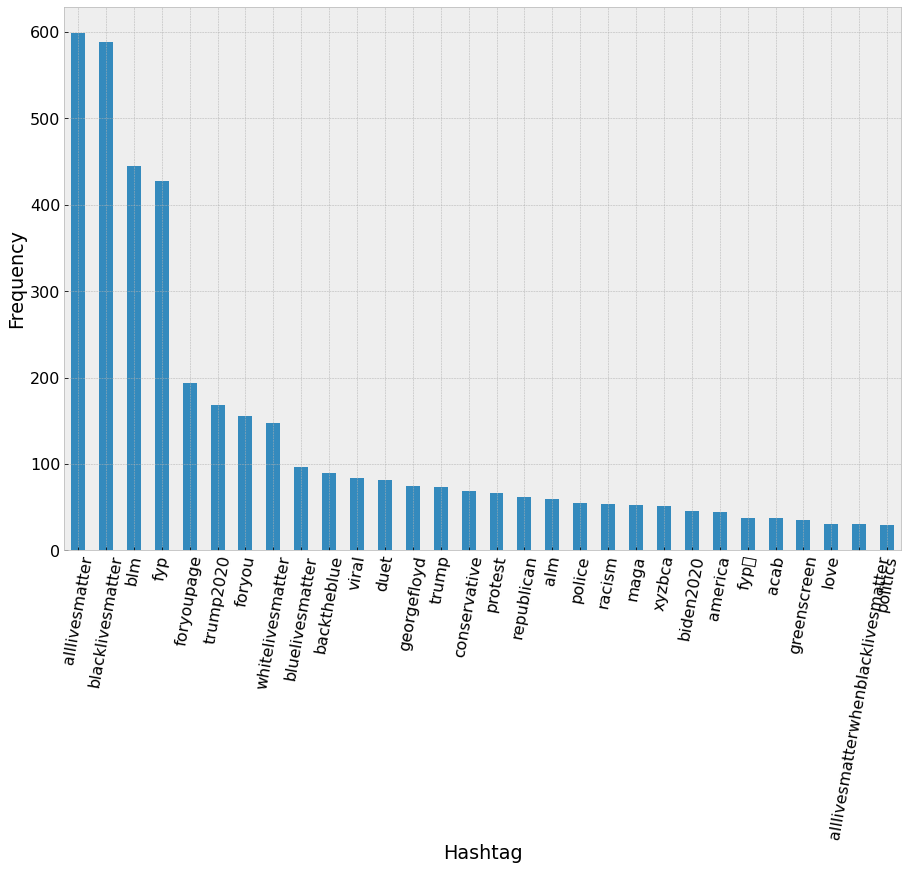

In [113]:
plt.figure(figsize=(15,10))
mid_hashtag_df['hashtag'].value_counts().head(30).plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.show()

### Hashtags used by unclassified users

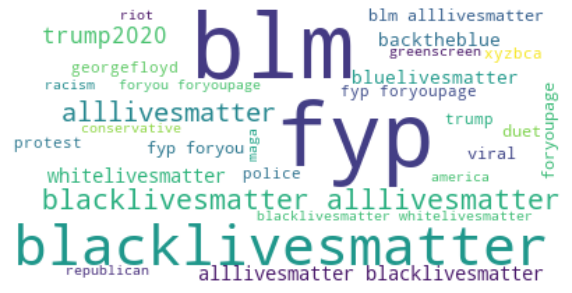

In [21]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(mid_hashtag_df.hashtag))
wordcloud.to_file("img/midBLMhashtags_all.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### with seed hashtags removed

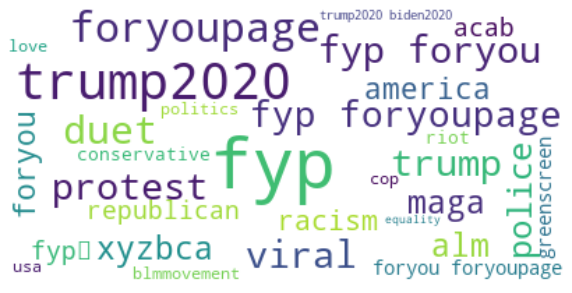

In [23]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(mid_hashtag_df[~mid_hashtag_df.hashtag.isin(hashtags_con+hashtags_pro)].hashtag))
wordcloud.to_file("img/midBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### all videos

In [558]:
all_hashtag_df = make_hashtag_dataframe(data_complete[data_complete.nr_hashtags > 0])

In [559]:
all_hashtag_df.shape

(301511, 3)

In [560]:
print('Number of unique hashtags in the dataset: ', len(all_hashtag_df.hashtag.unique()))

Number of unique hashtags in the dataset:  30536


### What are the most frequent hashtags in all data?

/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12471 missing from current font.
  font.set_text(s, 0, flags=flags)


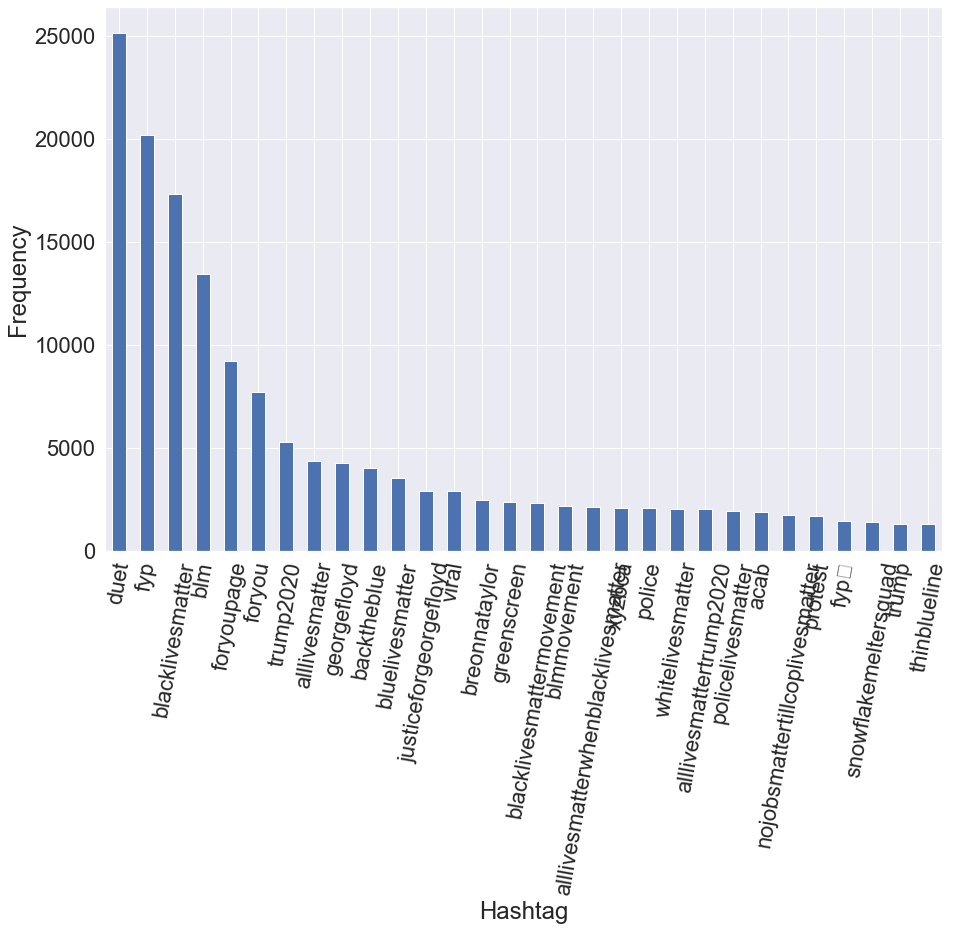

In [561]:
plt.figure(figsize=(15,10))
all_hashtag_df['hashtag'].value_counts().head(30).plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.show()

### Hashtags in the whole dataset

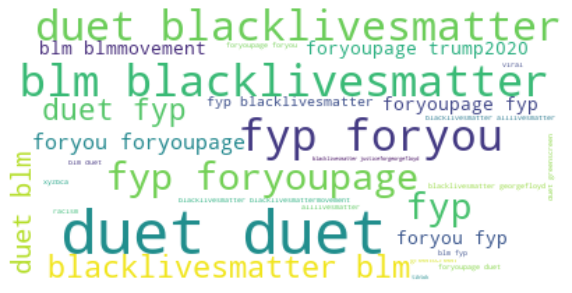

In [563]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(all_hashtag_df['hashtag']))
wordcloud.to_file("img/allBLMhashtags_all.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [564]:
all_hashtag_df['hashtag'].value_counts().head(40)

duet                                  25134
fyp                                   20166
blacklivesmatter                      17334
blm                                   13408
foryoupage                             9220
foryou                                 7719
trump2020                              5293
alllivesmatter                         4340
georgefloyd                            4236
backtheblue                            3988
bluelivesmatter                        3523
justiceforgeorgefloyd                  2898
viral                                  2880
breonnataylor                          2450
greenscreen                            2347
blacklivesmattermovement               2291
blmmovement                            2188
alllivesmatterwhenblacklivesmatter     2125
xyzbca                                 2070
police                                 2051
whitelivesmatter                       2018
alllivesmattertrump2020                1996
policelivesmatter               

### Hashtags for the whole dataset, with pro and con seeds removed

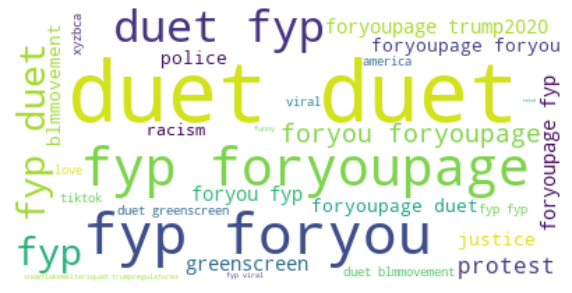

In [565]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=30, background_color="white").generate(' '.join(all_hashtag_df[~all_hashtag_df.hashtag.isin(hashtags_pro + hashtags_con)].hashtag))
wordcloud.to_file("img/allBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### no boosting tags or seed tags

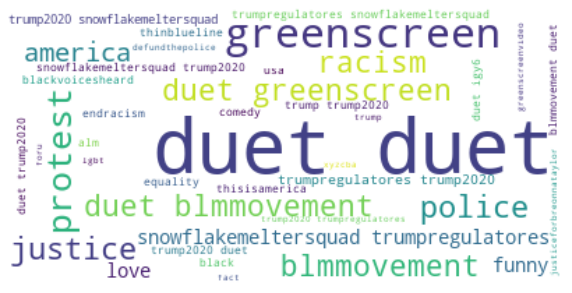

In [566]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_words=40, background_color="white").generate(' '.join(all_hashtag_df[~all_hashtag_df.hashtag.isin(hashtags_pro + hashtags_con + hashtags_boost)].hashtag))
wordcloud.to_file("img/allBLMhashtags_noseed.png")
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [567]:
all_hashtag_df[~all_hashtag_df.hashtag.isin(hashtags_pro + hashtags_con + hashtags_boost)].hashtag.value_counts().head(20)

duet                    25134
trump2020                5293
greenscreen              2347
blmmovement              2188
police                   2051
protest                  1695
snowflakemeltersquad     1369
trump                    1289
thinblueline             1276
copsoftiktok             1142
trumpregulatores         1030
igy6                     1009
justice                   912
america                   876
conservative              866
republican                822
cops                      777
racism                    766
funny                     743
maga                      733
Name: hashtag, dtype: int64

<center> <h2>Matching by sound</h2> </center>

### What are the most frequently used sounds that aren't original?

In [35]:
# TODO consider using what language original sound is classified as here as some proxy to foreign agents? 
# or maybe english as a second language speakers?

all_hashtag[~all_hashtag.music_title.isin(original_sound_dict)].music_title.value_counts().head(30)

Childish Gambino - This Is America / Post Malone - Congratulations    785
I NEED YOU TO                                                         404
Same Love (feat. Mary Lambert)                                        384
Mr Red White and Blue                                                 190
This Is America                                                       174
My Tears Are Becoming A Sea                                           108
Red Kingdom                                                            90
Surrender                                                              90
Officer Down                                                           75
オリジナル楽曲 - 🌏Samurai Tiktok🚀                                             58
Bad Boys (Theme From Cops)                                             56
"Go Go Go Who's Next?                                                  50
RIP Anthony Dia                                                        48
DJ Yames Mashup 6                     

### What are the most frequently used sounds in duets?

In [36]:
all_hashtag[(all_hashtag.duet_used == True) & (all_hashtag.nr_tags > 0)].music_title.value_counts().head(20)

original sound                                                        1110
Same Love (feat. Mary Lambert)                                          97
Childish Gambino - This Is America / Post Malone - Congratulations      34
Mr Red White and Blue                                                   12
Surrender                                                               11
I NEED YOU TO                                                           11
And thats on Black Lives Matter                                         10
RIP Anthony Dia                                                          9
Original Sound                                                           8
Right Back Where We Started From                                         8
Red Kingdom                                                              7
Magic In The Hamptons                                                    7
Worship Instrumental - Instrumental                                      6
Follow WOGASIANBRANDON   

### How many duets use original sound?

In [37]:
all_hashtag[(all_hashtag.duet_used == True) & (all_hashtag.nr_tags > 0) & (all_hashtag.music_title == 'original sound')].shape

(1110, 34)

### Are there some particular original sounds that are more popular in duets?

In [38]:
all_hashtag[(all_hashtag.duet_used == True) & 
          (all_hashtag.nr_tags > 0) & (all_hashtag.music_title == 'original sound')].music_id.value_counts().head(10)

6889175333107485446    8
6832735886413712133    6
6831679634426448645    6
6665542469326850822    6
6834966193955851014    6
6835463407244692230    6
6869460211468356358    6
6836924872862485254    5
6835345192418118406    5
6834302718052436742    5
Name: music_id, dtype: int64

### Get sound IDs for duets to search for more

In [40]:
duets_only = all_hashtag[all_hashtag.duet_used == True]

In [41]:
original_duets = duets_only[(duets_only.nr_tags > 0) & (duets_only.music_title == 'original sound')]

In [42]:
original_duets.shape

(1110, 34)

In [43]:
original_duets.to_csv('original_duets.csv')

<center> <h2>Parsing videos matched by sound</h2> </center>

In [46]:
df_dict = {}

# Parsing all sound files
for file in os.listdir('/Users/andreasipka/Desktop/TikTok/data/sound'):
    if file.endswith('_sound.csv'):
        df_dict['sound_'+file[:-10]] = pd.read_csv('data/sound/'+file)
        df_dict['sound_'+file[:-10]] = parse_table_raw(df_dict['sound_'+file[:-10]], file[:-10])
        
# Merge what we have
all_sound = pd.concat(df_dict.values())

### How many videos are there in the search-by-sound data?

In [221]:
all_sound.duet_used.value_counts()

True    22755
        12499
Name: duet_used, dtype: int64

In [222]:
print('Number of unique pro videos: ', len(all_sound[all_sound.leaning > 0].video_id.unique()))
print('Number of unique con videos: ', len(all_sound[all_sound.leaning < 0].video_id.unique()))
print('Number of unique unclassified videos: ', len(all_sound[all_sound.leaning == 0].video_id.unique()))
print('Total unique videos: ', len(all_sound.video_id.unique()))
print('Total unique users: ', len(all_sound.user_id.unique()))
print('Total videos with duet hashtag: ', all_sound[all_sound.duet_used == True].shape[0])
print('Total videos with a tagged used: ', all_sound[all_sound.nr_tags > 0].shape[0])
print('My best approximation for actual number of duets: ', all_sound[(all_sound.nr_tags > 0) & 
                                                                       (all_sound.duet_used)].shape[0])

Number of unique pro videos:  9139
Number of unique con videos:  1606
Number of unique unclassified videos:  24509
Total unique videos:  35254
Total unique users:  30914
Total videos with duet hashtag:  22755
Total videos with a tagged used:  25042
My best approximation for actual number of duets:  22439


### How many of those used #duet hashtag?

In [48]:
all_sound[all_sound.duet_used == True].shape[0]

22755

In [49]:
all_sound[(all_sound.duet_used == True) & (all_sound.tagged_users != '')].shape[0]

22439

### Merging both datasets

In [138]:
data_complete = pd.concat([all_sound, all_hashtag])

In [139]:
data_complete.shape[0]

60948

In [140]:
np.setdiff1d(all_sound.columns, all_hashtag.columns)

array(['duetInfo', 'stickerText'], dtype=object)

In [141]:
np.setdiff1d(all_hashtag.columns, all_sound.columns)

array(['duetEnabled'], dtype=object)

### Leanings distribution for sound videos

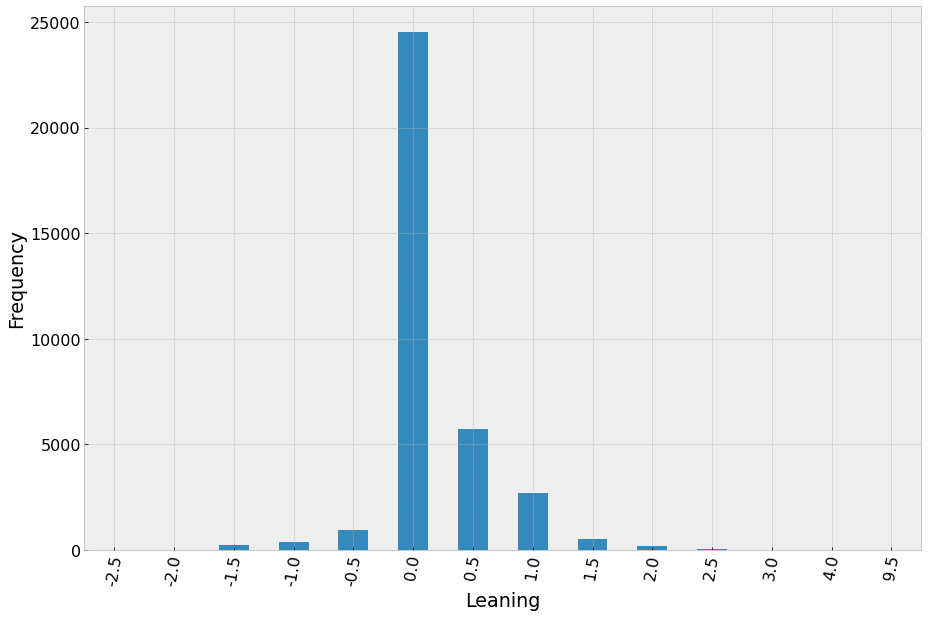

In [115]:
plt.figure(figsize=(15,10))
all_sound['leaning'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Leaning")
plt.ylabel("Frequency")
plt.show()

### leanings distribution for hashtag videos

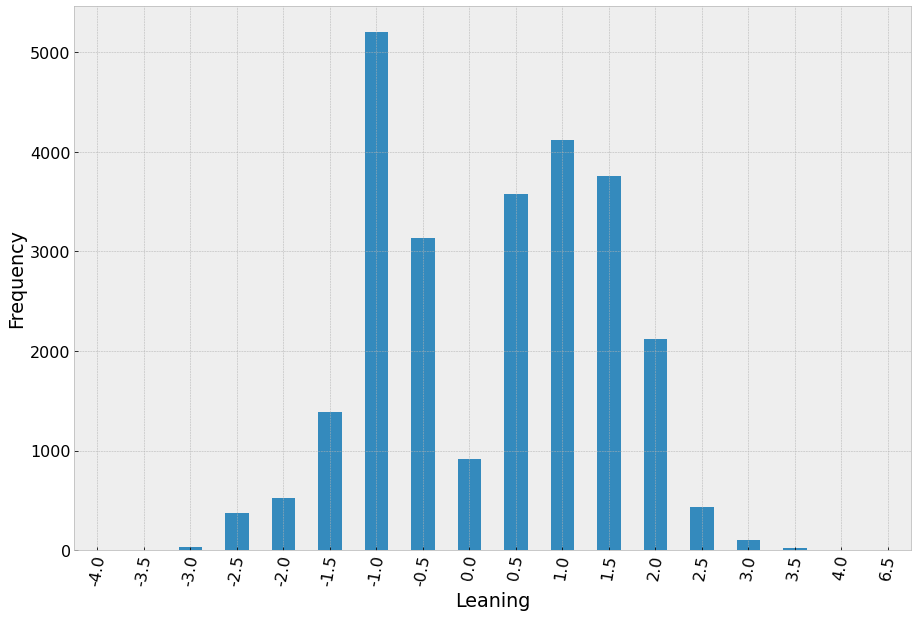

In [116]:
plt.figure(figsize=(15,10))
all_hashtag['leaning'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Leaning")
plt.ylabel("Frequency")
plt.show()

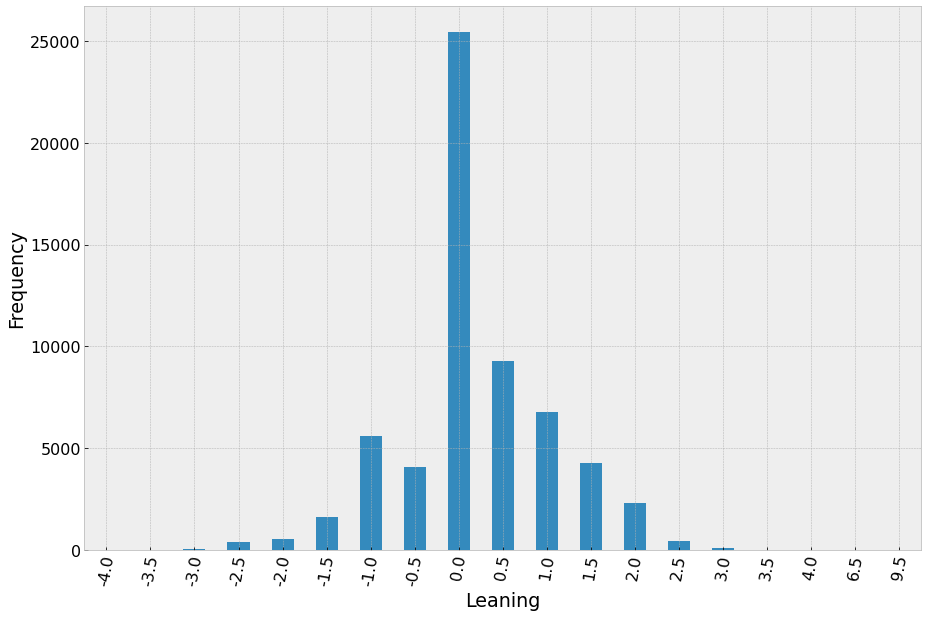

In [117]:
plt.figure(figsize=(15,10))
data_complete['leaning'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Leaning")
plt.ylabel("Frequency")
plt.show()

### How many videos do we have without hashtags?

In [91]:
data_complete[data_complete.nr_hashtags == 0].shape[0]

2802

<center> <h2>Cleaning + Analysing video descriptions</h2> </center>

In [198]:
vids_with_desc = data_complete[data_complete.video_desc != '']

In [204]:
vids_with_desc.shape

(59658, 45)

In [199]:
do_counts(vids_with_desc)

In [200]:
# Add columns for values to be stored
vids_with_desc['video_desc_cleaned'] = vids_with_desc['video_desc']
vids_with_desc['num_emoji'] = 0
vids_with_desc['video_desc_nostop'] = ''

vids_with_desc = vids_with_desc.apply(clean_text, axis=1)

In [210]:
vids_with_desc = vids_with_desc[['video_id', 'video_desc', 'user_signature',
       'nr_hashtags', 'hashtags_used', 'nr_tags', 'tagged_users', 'duet_used',
       'stickerText', 'leaning', 'word_count', 'character_count', 'avg_word_length',
       'stopwords', 'upper', 'video_desc_cleaned', 'num_emoji', 'num_hashtag',
       'video_desc_nostop']]

### Save to CSV

In [215]:
# full CSV
data_complete.to_csv('data_complete.csv')

# only duets
data_complete[(data_complete.nr_tags > 0) & (data_complete.duet_used)].to_csv('duets_only.csv')

# text analysis 
vids_with_desc.to_csv('text_analysis.csv')

## Fix data formatting with IDs not being ints

In [260]:
data_complete.fillna(value={'duetInfo': 0}, inplace=True)

In [261]:
data_complete.duetInfo = data_complete.duetInfo.astype(int)

In [612]:
# full CSV export
data_complete.to_csv('data_complete.csv')

## Read in whole dataset

In [3]:
data_complete = pd.read_csv('data_complete.csv')

/Users/andreasipka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (30,31,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
data_complete.shape

(60948, 37)

In [7]:
data_complete[data_complete.duet_used == True].shape

(24719, 37)

In [8]:
len(data_complete.user_id.unique())

44008

In [10]:
data_complete[data_complete.leaning > 0].shape

(23265, 37)

In [11]:
data_complete[data_complete.leaning < 0].shape

(12259, 37)

# Modelling as hashtag network

In [53]:
data_complete[data_complete.nr_hashtags > 0].shape

(58146, 37)

In [46]:
data_complete.shape

(60948, 37)

In [54]:
complete_hashtag_df = make_hashtag_dataframe(data_complete[data_complete.nr_hashtags > 0])

In [55]:
complete_hashtag_df.head()

,user_id,video_id,hashtag
0,6804890842937443334,6847589178792807685,duet
1,6804890842937443334,6847589178792807685,✊🏽✊🏾✊🏿
2,6804890842937443334,6847589178792807685,black❤️
3,6820171986931008517,6841218359292431621,duet
4,6810892895605376005,6849535754964716805,duet


In [56]:
complete_hashtag_df.shape

(301511, 3)

In [59]:
complete_hashtag_df.to_csv('data/hashtag_data.csv', index=False)

## Getting new tables for network modelling in visone

## File 1: user attributes

In [89]:
def make_ul_df_1(df):
        
    list_to_save = []
    
    unique_user_list = df.user_id.unique()
    
    for user in unique_user_list:
        hashlistusr = []
        
        for index, row in df[df.user_id == user].iterrows():            
            for hashtag in row['hashtags_used'].split(', '):
                hashlistusr.append(hashtag)
                
        list_to_save.append([user, df[df.user_id == user].shape[0], len(hashlistusr), len(set(hashlistusr))])
            
    return pd.DataFrame(list_to_save, columns=['user_id', 'no_of_videos', 'no_of_hashtags', 'no_of_unique_hashtags'])

In [90]:
ul_df_1 = make_ul_df_1(data_complete[data_complete.nr_hashtags > 0])

In [91]:
ul_df_1.head()

,user_id,no_of_videos,no_of_hashtags,no_of_unique_hashtags
0,6804890842937443334,1,3,3
1,6820171986931008517,1,1,1
2,6810892895605376005,1,3,3
3,6603423061034500101,1,1,1
4,6790081948297036805,3,12,10


In [92]:
ul_df_1.to_csv('data/ul_data_1.csv', index=False)

## File 2: Video attributes

In [93]:
data_complete[data_complete.nr_hashtags > 0].shape

(58146, 37)

In [97]:
ul_df_2 = data_complete[data_complete.nr_hashtags > 0][['video_id', 'nr_hashtags']]

In [99]:
ul_df_2.to_csv('data/ul_data_2.csv', index=False)

## File 3: user-video-hashtag links

In [100]:
complete_hashtag_df.head()

,user_id,video_id,hashtag
0,6804890842937443334,6847589178792807685,duet
1,6804890842937443334,6847589178792807685,✊🏽✊🏾✊🏿
2,6804890842937443334,6847589178792807685,black❤️
3,6820171986931008517,6841218359292431621,duet
4,6810892895605376005,6849535754964716805,duet


In [106]:
ul_df_3 = complete_hashtag_df['hashtag'].value_counts().to_frame()

In [163]:
ul_df_3.head()

,hashtag
duet,25134
fyp,20166
blacklivesmatter,17334
blm,13408
foryoupage,9220


In [164]:
ul_df_3.to_csv('data/ul_data_3.csv')

## File 4: Hashtag attributes

In [110]:
def make_ul_df_4(df):
        
    list_to_save = []
    
    unique_user_list = df.user_id.unique()
    
    for user in unique_user_list:
        hashlistusr = []
        
        for index, row in df[df.user_id == user].iterrows():            
            for hashtag in row['hashtags_used'].split(', '):
                hashlistusr.append(hashtag)
        
        for hashtag in set(hashlistusr):
            list_to_save.append([user, hashtag, hashlistusr.count(hashtag)])
                            
    return pd.DataFrame(list_to_save, columns=['user_id', 'hashtag', 'no_of_uses'])

In [111]:
ul_df_4 = make_ul_df_4(data_complete[data_complete.nr_hashtags > 0])

In [112]:
ul_df_4.head()

,user_id,hashtag,no_of_uses
0,6804890842937443334,black❤️,1
1,6804890842937443334,✊🏽✊🏾✊🏿,1
2,6804890842937443334,duet,1
3,6820171986931008517,duet,1
4,6810892895605376005,blm,1


In [118]:
ul_df_4[ul_df_4.no_of_uses > 1].to_csv('data/ul_data_4.csv', index=False)

## File 5: Hashtag coocurrence

In [5]:
def make_ul_df_5(df):
        
    list_to_save = []
    
    for index, row in df.iterrows():
        hashtaglist = row['hashtags_used'].split(', ')
        
        for h1, h2 in combinations(hashtaglist, 2):
            list_to_save.append([h1, h2, row['user_id']])
            
    return pd.DataFrame(list_to_save, columns=['hashtag1', 'hashtag2', 'user_id'])

In [6]:
ul_df_5 = make_ul_df_5(data_complete[data_complete.nr_hashtags > 1])

In [7]:
ul_df_5.shape

(949643, 3)

In [15]:
ul_df_5.head()

,hashtag1,hashtag2,user_id
0,duet,✊🏽✊🏾✊🏿,6804890842937443334
1,duet,black❤️,6804890842937443334
2,✊🏽✊🏾✊🏿,black❤️,6804890842937443334
3,duet,blacklivesmatter,6810892895605376005
4,duet,blm,6810892895605376005


In [17]:
def fix_permutations(df):
        
    list_to_save = []
    
    for index, row in df.iterrows():
        
        if row['hashtag1'] < row['hashtag2']:
            list_to_save.append([row['hashtag1'], row['hashtag2'], row['user_id']])
        else:
            list_to_save.append([row['hashtag2'], row['hashtag1'], row['user_id']])
            
    return pd.DataFrame(list_to_save, columns=['hashtag1', 'hashtag2', 'user_id'])

In [18]:
ul_df_5_sorted = fix_permutations(ul_df_5)

In [27]:
ul_df_5_cooc = ul_df_5_sorted.groupby(["hashtag1", "hashtag2"]).size().reset_index(name="co_occurences")

In [28]:
ul_df_5_cooc.head()

,hashtag1,hashtag2,co_occurences
0,01,100k,1
1,01,follow,1
2,01,foryou,1
3,01,fyp,1
4,01,떡상하자,1


In [49]:
ul_df_5_cooc[ul_df_5_cooc.co_occurences > 2].shape

(40712, 3)

In [616]:
ul_df_5_cooc[ul_df_5_cooc.co_occurences > 2].sort_values(by=['co_occurences'], ascending=False).head(15)

,hashtag1,hashtag2,co_occurences
68038,blacklivesmatter,blm,7621
70061,blacklivesmatter,fyp,6773
188301,foryoupage,fyp,6303
150869,duet,fyp,6156
69269,blacklivesmatter,duet,5940
182601,foryou,fyp,5868
86947,blm,fyp,5864
86237,blm,duet,4519
182426,foryou,foryoupage,3254
69860,blacklivesmatter,foryoupage,2986


In [52]:
def get_unique_user_coocs(df, sorted_df):
        
    list_to_save = []
    
    for index, row in df.iterrows():
        
        no_user = len(sorted_df[(sorted_df.hashtag1 == row['hashtag1']) & (sorted_df.hashtag2 == row['hashtag2'])].user_id.unique())
        
        list_to_save.append([row['hashtag1'], row['hashtag2'], row['co_occurences'], no_user])
            
    return pd.DataFrame(list_to_save, columns=['hashtag1', 'hashtag2', 'co_occurences', 'no_users'])

In [64]:
ul_df_5_cooc_complete = get_unique_user_coocs(ul_df_5_cooc[ul_df_5_cooc.co_occurences > 2], ul_df_5_sorted)

In [65]:
ul_df_5_cooc_complete.head()

,hashtag1,hashtag2,co_occurences,no_users
0,0carne,fyp,3,1
1,1,blm,6,4
2,1,foryoupage,3,3
3,1,fyp,5,4
4,1,fypthis,4,1


In [162]:
ul_df_5_cooc[ul_df_5_cooc.co_ocurrences > 2].to_csv('data/ul_data_5.csv', index=False)

## Recalculate leaning with more hashtag labels

In [617]:
data_complete[data_complete.nr_hashtags > 0][['video_id', 'hashtags_used', 'leaning', 'label']].sample(20)

,video_id,hashtags_used,leaning,label
11451,6833765732673785093,"blacklivesmatter, blm",1.0,pro
8961,6832255816029015301,duet,0.0,neutral
26588,6865754419997314310,"family, lostandbroken, hope, dontquit, fyp, foryoupage",0.0,neutral
57368,6872870425974672642,"fyp, viral, breonnataylor, ghostphotoshoot, fypシ",0.5,pro
56950,6882472293767941382,"duet, ladycop, thinblueline, firstresponder, copsoftiktok, cops, femalestrong, officer, policelivesmatter",-1.0,con
36289,6833911607731555589,"duet, blacklivesmattermovement, blmmovement, healthyliving, nojusticenopeace, thisisamerica, momlife",1.0,pro
50172,6834151977539210497,"georgefloyd, blacklivesmatter, basketball, basketballchallenge",1.0,pro
22621,6833766278281448710,duet,0.0,neutral
58548,6865648473371348229,"blacklivesmatter, unity, fedup, jacobblake, georgefloyd, breonnataylor",1.5,pro
6957,6840999547137772806,"duet, gay, dadsoftiktok, yogaflow, lgbt",0.0,neutral


In [79]:
def leaning_new(s):
    s['leaning_new'] = hash_to_leaning(s['hashtags_used'].split(', '))
    return s

In [83]:
data_complete_hashtags = data_complete[data_complete.nr_hashtags > 0]

In [84]:
data_complete_hashtags['leaning_new'] = ''
data_complete_hashtags = data_complete_hashtags.apply(leaning_new, axis=1)

In [85]:
data_complete_hashtags.shape

(58146, 39)

In [90]:
# create a list of our conditions
conditions = [
    (data_complete_hashtags['leaning_new'] > 0),
    (data_complete_hashtags['leaning_new'] == 0),
    (data_complete_hashtags['leaning_new'] < 0)
    ]

# create a list of the values we want to assign for each condition
values = ['pro', 'neutral', 'con']

# create a new column and use np.select to assign values to it using our lists as arguments
data_complete_hashtags['label_new'] = np.select(conditions, values)

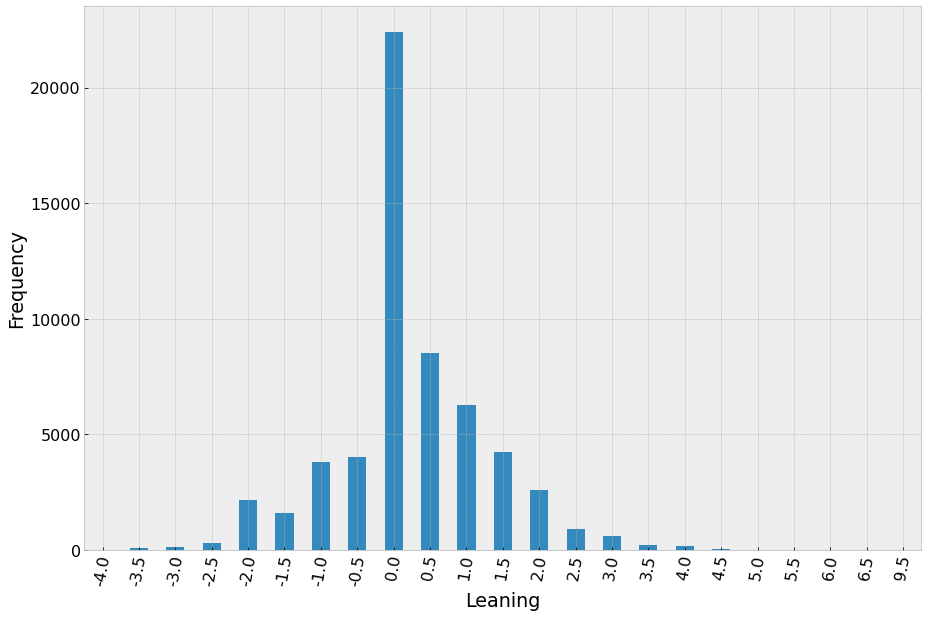

In [208]:
plt.figure(figsize=(15,10))
data_complete_hashtags['leaning_new'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Leaning")
plt.ylabel("Frequency")
plt.show()

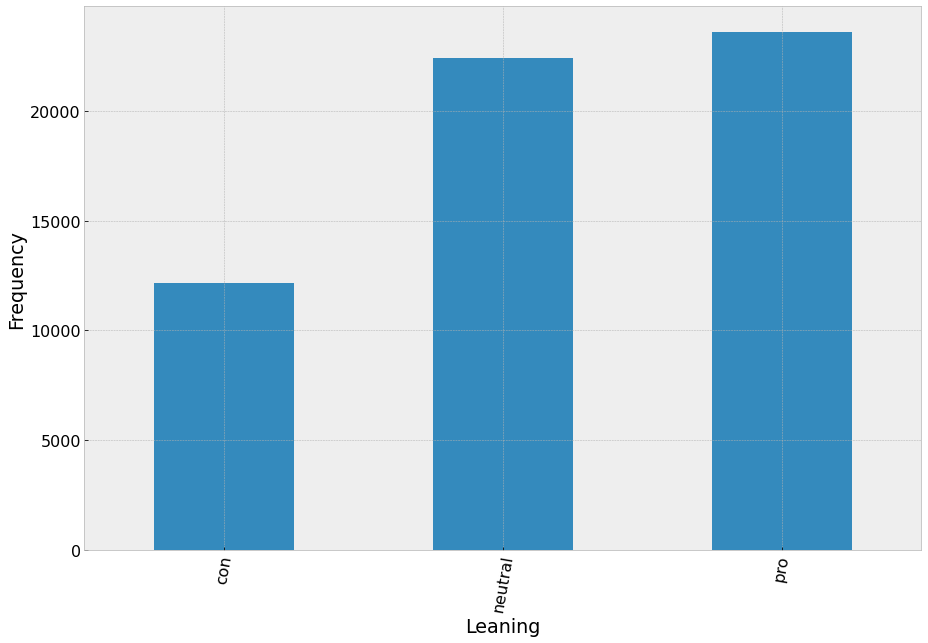

In [209]:
plt.figure(figsize=(15,10))
data_complete_hashtags['label_new'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Leaning")
plt.ylabel("Frequency")
plt.show()

In [94]:
data_complete_hashtags.label_new.value_counts()

pro        23593
neutral    22393
con        12160
Name: label_new, dtype: int64

In [639]:
data_complete_hashtags.to_csv('data/complete_tiktok_data.csv', index=False)

In [238]:
video_attributes = data_complete_hashtags[['video_id', 'stats_likes', 'stats_shares', 'stats_comments', 'stats_plays', 'video_length', 'nr_hashtags', 'nr_tags', 'leaning_new', 'label_new']]

In [239]:
video_attributes.head()

,video_id,stats_likes,stats_shares,stats_comments,stats_plays,video_length,nr_hashtags,nr_tags,leaning_new,label_new
1,6847589178792807685,386.0,47.0,10.0,5220.0,3.0,3,1,0.0,neutral
2,6841218359292431621,51.0,7.0,2.0,531.0,3.0,1,1,0.0,neutral
3,6849535754964716805,47.0,1.0,3.0,244.0,3.0,3,1,1.0,pro
4,6850602455420488966,44.0,1.0,1.0,322.0,3.0,1,0,0.5,pro
5,6844638328000761093,42.0,4.0,1.0,264.0,3.0,5,1,0.5,pro


In [240]:
video_attributes.shape

(58146, 10)

In [241]:
video_attributes.to_csv('data/video_labels.csv', index=False)

## Get duets only

In [106]:
data_complete_hashtags[data_complete_hashtags.duetInfo != 0].shape

(24028, 40)

In [107]:
data_complete_hashtags[data_complete_hashtags.duet_used == True].shape

(24719, 40)

In [108]:
duet_data = data_complete_hashtags[data_complete_hashtags.duetInfo != 0]

## Get user attributes

In [116]:
user_leaning_table = data_complete_hashtags.groupby('user_id')['leaning_new'].agg('sum').reset_index(name="user_leaning")

In [119]:
# create a list of our conditions
conditions = [
    (user_leaning_table['user_leaning'] > 0),
    (user_leaning_table['user_leaning'] == 0),
    (user_leaning_table['user_leaning'] < 0)
    ]

# create a list of the values we want to assign for each condition
values = ['pro', 'neutral', 'con']

# create a new column and use np.select to assign values to it using our lists as arguments
user_leaning_table['leaning_new'] = np.select(conditions, values)

In [120]:
user_leaning_table.head()

,user_id,user_leaning,leaning_new
0,73707,0.0,neutral
1,94772,3.0,pro
2,99896,0.5,pro
3,105232,0.5,pro
4,117368,2.0,pro


In [121]:
user_video_no = data_complete_hashtags['user_id'].value_counts().to_frame()

In [125]:
user_video_no.columns = ['no_vids']

In [126]:
user_video_no.head()

,no_vids
178208964185067520,1665
6862902950680904710,194
6873129382920963077,162
6866974512816342021,90
6870897063875871749,73


In [127]:
user_leaning_table = user_leaning_table.merge(user_video_no, left_on='user_id', right_index = True)

In [129]:
user_leaning_table.columns = ['user_id', 'leaning', 'label', 'no_videos']

In [170]:
user_leaning_table.head()

,user_id,leaning,label,no_videos
0,73707,0.0,neutral,1
1,94772,3.0,pro,3
2,99896,0.5,pro,1
3,105232,0.5,pro,1
4,117368,2.0,pro,2


In [171]:
user_leaning_table['leaning_avg'] = user_leaning_table['leaning'] / user_leaning_table['no_videos']

In [176]:
data_complete[['user_id', 'user_name']].head()

,user_id,user_name
0,6814185393371497478,jgasana3
1,6804890842937443334,eyronsmithsr
2,6820171986931008517,lovingmeso
3,6810892895605376005,kingjustice85
4,6603423061034500101,missmiller85


In [177]:
user_leaning_table = user_leaning_table.merge(data_complete[['user_id', 'user_name']], left_on='user_id', right_on='user_id')

In [178]:
user_leaning_table[['user_id', 'label', 'no_videos', 'leaning_avg', 'user_name']].head()

,user_id,label,no_videos,leaning_avg,user_name
0,73707,neutral,1,0.0,sharly_p
1,94772,pro,3,1.0,itsbriannaballard
2,94772,pro,3,1.0,itsbriannaballard
3,94772,pro,3,1.0,itsbriannaballard
4,99896,pro,1,0.5,perris.howard


In [179]:
user_leaning_table.shape

(58413, 6)

In [182]:
user_leaning_table = user_leaning_table.drop_duplicates(subset=['user_id'])

In [183]:
user_leaning_table.shape

(41586, 6)

In [184]:
user_leaning_table[['user_id', 'label', 'no_videos', 'leaning_avg', 'user_name']].to_csv('data/user_labels.csv', index=False)

### add more user attributes

In [213]:
user_leaning_table.shape

(41586, 6)

In [214]:
user_leaning_table = user_leaning_table.merge(data_complete[['user_id', 'authorstats_following', 'authorstats_followers', 'authorstats_heart', 'authorstats_videos', 'authorstats_diggs']], left_on='user_id', right_on='user_id')

In [215]:
user_leaning_table.shape

(58413, 11)

In [216]:
user_leaning_table = user_leaning_table.drop_duplicates(subset=['user_id'])

In [217]:
user_leaning_table.shape

(41586, 11)

In [230]:
user_leaning_table = user_leaning_table.merge(ul_df_1[['user_id', 'no_of_hashtags', 'no_of_unique_hashtags']], left_on='user_id', right_on='user_id')

In [231]:
user_leaning_table.shape

(41586, 13)

In [233]:
user_leaning_table.to_csv('data/user_labels.csv', index=False)

### add attributes related to BLM videos

In [328]:
user_stats_table = data_complete_hashtags.drop_duplicates(subset=['video_id']).groupby('user_id')[['stats_likes', 'stats_shares', 'stats_comments', 'stats_plays']].agg('mean').reset_index()

In [334]:
user_leaning_table = user_leaning_table.merge(user_stats_table, left_on='user_id', right_on='user_id')

In [337]:
user_leaning_table.to_csv('data/user_labels.csv', index=False)

## Duet data export - video to video links

In [137]:
duet_data[['duetInfo', 'video_id', 'user_id', 'video_desc', 'tagged_users', 'label_new']].sample(10)

,duetInfo,video_id,user_id,video_desc,tagged_users,label_new
15884,6863093042275044352,6863115764589743366,6772399736856675333,#duet with @kaykayyyy_87,6775607045649105926,neutral
5071,6854990795271900160,6855312373859863813,6687691381233091589,#duet with @roddyrichiee,6731894955424842758,neutral
11750,6831975529034288128,6832415825031597318,6617279114313367557,#duet with @taylormadexxx #TheHighNote talk yo shit den,6684799175513179142,neutral
15898,6861650066491362304,6863558616020995334,6571165326607958021,#duet with @drizz3yy oh forsur,6653181174615244806,neutral
3553,6836924919478111232,6837573849723194630,60544726994526208,#duet with @jackiekamel,150720527609769984,neutral
27338,6832413374278732800,6835355499660184838,6808234641331291142,#duet with @574whitegirl #blacklivesmatter #blm #blmmovement,6620896275339919365,pro
1377,6873520215922117632,6873565390883015941,6662316036072783877,#duet with @_lil.pouty_ he’s on to something.... #blacklivesmatter #bluelivesdontexist #dumptrump #covid_19 #anybodyelse2020,87115910972350464,pro
32036,6833144229150084096,6833591538933615877,6587329401058623493,#duet with @jaasona,6810501489330668550,neutral
25760,6831679650956135424,6831982081761889542,6769969333658551301,#duet with @southernsheriff #foryourpage #justiceforgeorgefloyd #alllivesmatter,6573517053457514502,pro
20485,6833163946011429888,6833243189634288902,149084052191485952,#duet with @auntieneutron_420 #foryoupage #shesrightyouknow #shesaidwhatshesaid #fyp #violenceisnottheanswer,6817870701509313542,neutral


In [136]:
duet_data[['video_id', 'duetInfo']].to_csv('data/duet_pairs.csv', index=False)

## Duet data export - user to user links

In [186]:
duet_data.nr_tags.value_counts()

1    23065
0      530
2      308
3       49
4       29
5       20
6       11
7        8
8        7
9        1
Name: nr_tags, dtype: int64

In [192]:
def make_tag_duet_dataframe(df):
        
    list_to_save = []
    
    for index, row in df.iterrows():
        if row['nr_tags'] == 1:
            list_to_save.append([row['user_id'], row['tagged_users'], row['video_id']])
        elif row['nr_tags'] > 1:
            list_to_save.append([row['user_id'], row['tagged_users'].split(', ')[0], row['video_id']])
            
    return pd.DataFrame(list_to_save, columns=['user_id', 'tagged_id', 'video_id'])

In [193]:
who_duetted_with_whom = make_tag_duet_dataframe(duet_data)

In [204]:
who_duetted_with_whom[['user_id', 'tagged_id']].to_csv('data/duet_user_pairs.csv', index=False)

In [201]:
who_duetted_with_whom_cooc = who_duetted_with_whom.groupby(["user_id", 
                                                            "tagged_id"]).size().reset_index(name="co_occurences")

In [202]:
who_duetted_with_whom_cooc.shape

(23376, 3)

In [205]:
who_duetted_with_whom_cooc.to_csv('data/duet_user_pairs.csv', index=False)

### determining agreement vs disagreement in duets

In [345]:
user_leaning_table[['user_id', 'label']].head()

,user_id,label
0,73707,neutral
1,94772,pro
2,99896,pro
3,105232,pro
4,117368,pro


In [355]:
who_duetted_with_whom_cooc = who_duetted_with_whom_cooc.merge(user_leaning_table[['user_id', 'label']], left_on='user_id', right_on='user_id')

In [354]:
who_duetted_with_whom_cooc.tagged_id = who_duetted_with_whom_cooc.tagged_id.astype(int)

In [357]:
who_duetted_with_whom_cooc.columns = ['user1', 'user_id', 'co_occurences', 'label1']

In [360]:
who_duetted_with_whom_cooc = who_duetted_with_whom_cooc.merge(user_leaning_table[['user_id', 'label']], left_on='user_id', right_on='user_id')

In [361]:
who_duetted_with_whom_cooc.shape

(20292, 5)

In [362]:
who_duetted_with_whom_cooc.head()

,user1,user_id,co_occurences,label1,label
0,154547,6724511517688071174,1,pro,pro
1,370496,6724511517688071174,1,pro,pro
2,3731242,6724511517688071174,1,pro,pro
3,4485058,6724511517688071174,1,pro,pro
4,4855799,6724511517688071174,1,pro,pro


In [364]:
who_duetted_with_whom_cooc[who_duetted_with_whom_cooc.label1 != who_duetted_with_whom_cooc.label].shape

(9762, 5)

In [365]:
who_duetted_with_whom_cooc[(who_duetted_with_whom_cooc.label1 == 'pro') & (who_duetted_with_whom_cooc.label == 'con')].shape

(155, 5)

In [366]:
who_duetted_with_whom_cooc[(who_duetted_with_whom_cooc.label1 == 'con') & (who_duetted_with_whom_cooc.label == 'pro')].shape

(442, 5)

In [367]:
who_duetted_with_whom_cooc[(who_duetted_with_whom_cooc.label1 == 'pro') & (who_duetted_with_whom_cooc.label == 'neutral')].shape

(1002, 5)

In [368]:
who_duetted_with_whom_cooc[(who_duetted_with_whom_cooc.label1 == 'con') & (who_duetted_with_whom_cooc.label == 'neutral')].shape

(318, 5)

In [380]:
who_duetted_with_whom_cooc.columns = ['user_id', 'tagged_id', 'co_occurences', 'user_label', 'tagged_label']

In [381]:
who_duetted_with_whom_cooc.head()

,user_id,tagged_id,co_occurences,user_label,tagged_label
0,154547,6724511517688071174,1,pro,pro
1,370496,6724511517688071174,1,pro,pro
2,3731242,6724511517688071174,1,pro,pro
3,4485058,6724511517688071174,1,pro,pro
4,4855799,6724511517688071174,1,pro,pro


In [382]:
# create a list of our conditions
conditions = [
    (who_duetted_with_whom_cooc.user_label == 'con') & (who_duetted_with_whom_cooc.tagged_label == 'neutral'),
    (who_duetted_with_whom_cooc.user_label == 'pro') & (who_duetted_with_whom_cooc.tagged_label == 'neutral'),
    (who_duetted_with_whom_cooc.user_label == 'neutral') & (who_duetted_with_whom_cooc.tagged_label == 'pro'),
    (who_duetted_with_whom_cooc.user_label == 'neutral') & (who_duetted_with_whom_cooc.tagged_label == 'con'),
    (who_duetted_with_whom_cooc.user_label == 'pro') & (who_duetted_with_whom_cooc.tagged_label == 'pro'),
    (who_duetted_with_whom_cooc.user_label == 'con') & (who_duetted_with_whom_cooc.tagged_label == 'con'),
    (who_duetted_with_whom_cooc.user_label == 'neutral') & (who_duetted_with_whom_cooc.tagged_label == 'neutral'),
    (who_duetted_with_whom_cooc.user_label == 'pro') & (who_duetted_with_whom_cooc.tagged_label == 'con'),
    (who_duetted_with_whom_cooc.user_label == 'con') & (who_duetted_with_whom_cooc.tagged_label == 'pro'),
    ]

# create a list of the values we want to assign for each condition
values = ['neutral', 'neutral', 'neutral', 'neutral', 'agree', 'agree', 'agree', 'disagree', 'disagree']

# create a new column and use np.select to assign values to it using our lists as arguments
who_duetted_with_whom_cooc['link_label'] = np.select(conditions, values)

In [387]:
who_duetted_with_whom_cooc[who_duetted_with_whom_cooc.link_label == 'neutral'].sample(5)

,user_id,tagged_id,co_occurences,user_label,tagged_label,link_label
2489,6781300914617156614,6755114752386630662,1,neutral,pro,neutral
16831,85955201513218048,6617962047891341318,1,neutral,pro,neutral
16793,6816094686832165893,6769364163460776966,1,neutral,con,neutral
9891,6826154572172559365,6793847980245304322,1,neutral,pro,neutral
7177,6853275197077668870,6703126725822104582,1,neutral,pro,neutral


In [389]:
who_duetted_with_whom_cooc[['user_id', 'tagged_id', 'co_occurences', 'link_label']].to_csv('data/duet_user_pairs_labeled.csv', index=False)

## Tagged data export - who tagged whom

In [143]:
def make_tag_dataframe(df):
        
    list_to_save = []
    
    for index, row in df.iterrows():
        if row['nr_tags'] == 1:
            list_to_save.append([row['user_id'], row['tagged_users'], row['video_id']])
        else:
            for taggeduser in row['tagged_users'].split(', '):
                list_to_save.append([row['user_id'], taggeduser, row['video_id']])
            
    return pd.DataFrame(list_to_save, columns=['user_id', 'tagged_id', 'video_id'])

In [144]:
tagged_df = make_tag_dataframe(data_complete_hashtags[data_complete_hashtags.nr_tags > 0])

In [286]:
tagged_df.head()

,user_id,tagged_id,video_id
0,6804890842937443334,6814185393371497478,6847589178792807685
1,6820171986931008517,6814185393371497478,6841218359292431621
2,6810892895605376005,6814185393371497478,6849535754964716805
3,6790081948297036805,6814185393371497478,6844638328000761093
4,6635722863121448966,6814185393371497478,6849891938926120197


In [287]:
tagged_df.shape

(30740, 3)

In [288]:
len(tagged_df.user_id.unique())

23565

In [289]:
tagged_df_wnums = tagged_df.groupby(["user_id", "tagged_id"]).size().reset_index(name="co_occurences")

In [290]:
tagged_df_wnums.head()

,user_id,tagged_id,co_occurences
0,154547,6724511517688071174,1
1,184640,150720527609769984,2
2,184640,6603801426278547461,1
3,184640,6613538231022780421,1
4,184640,6733680085255209990,1


In [291]:
tagged_df_wnums.co_occurences.value_counts()

1     28291
2       707
3       129
4        38
5        16
6         8
7         5
9         3
13        2
14        2
8         2
24        2
10        2
22        1
25        1
18        1
11        1
12        1
80        1
Name: co_occurences, dtype: int64

In [292]:
tagged_df_wnums[tagged_df_wnums.co_occurences > 20]

,user_id,tagged_id,co_occurences
2669,178208964185067520,6592395521522925573,24
2710,178208964185067520,6618904824282988549,80
2770,178208964185067520,6650048810167746565,24
3016,178208964185067520,6785975778510980102,22
29197,6885455408660644870,6873129382920963077,25


In [294]:
tagged_df_wnums.to_csv('data/tagged_pairs.csv', index=False)

## Exploring video attributes

In [242]:
video_attributes.head()

,video_id,stats_likes,stats_shares,stats_comments,stats_plays,video_length,nr_hashtags,nr_tags,leaning_new,label_new
1,6847589178792807685,386.0,47.0,10.0,5220.0,3.0,3,1,0.0,neutral
2,6841218359292431621,51.0,7.0,2.0,531.0,3.0,1,1,0.0,neutral
3,6849535754964716805,47.0,1.0,3.0,244.0,3.0,3,1,1.0,pro
4,6850602455420488966,44.0,1.0,1.0,322.0,3.0,1,0,0.5,pro
5,6844638328000761093,42.0,4.0,1.0,264.0,3.0,5,1,0.5,pro


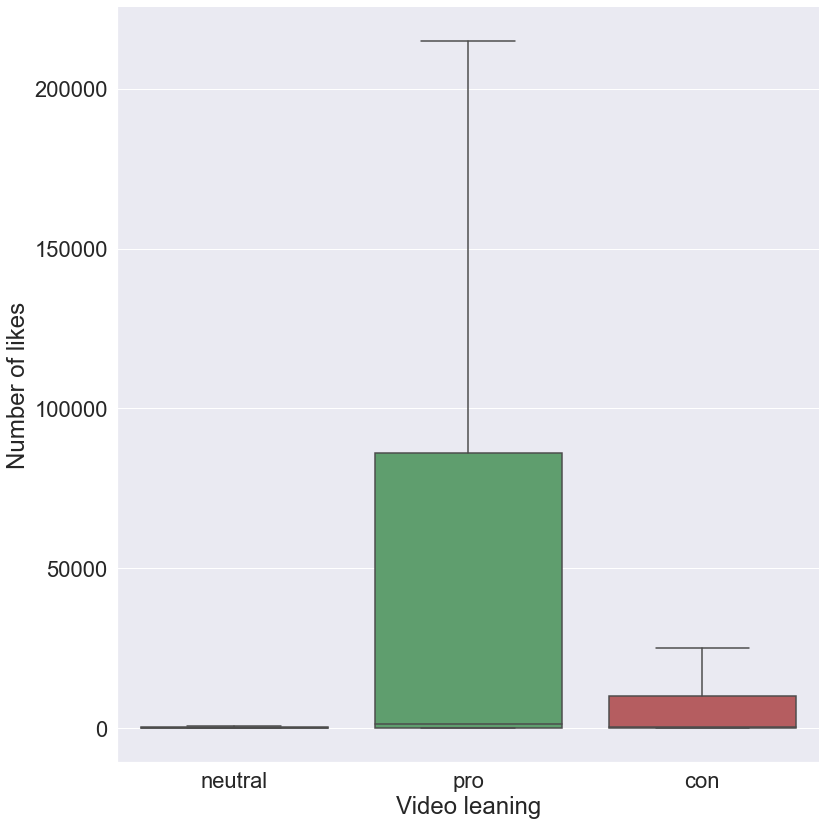

In [533]:
sns_plot = sns.catplot(x="label_new", y="stats_likes", kind="box", 
                       data=video_attributes, showfliers = False,
                       height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("Video leaning")
plt.ylabel("Number of likes")
sns_plot.savefig("video_likes_vs_labels.png")

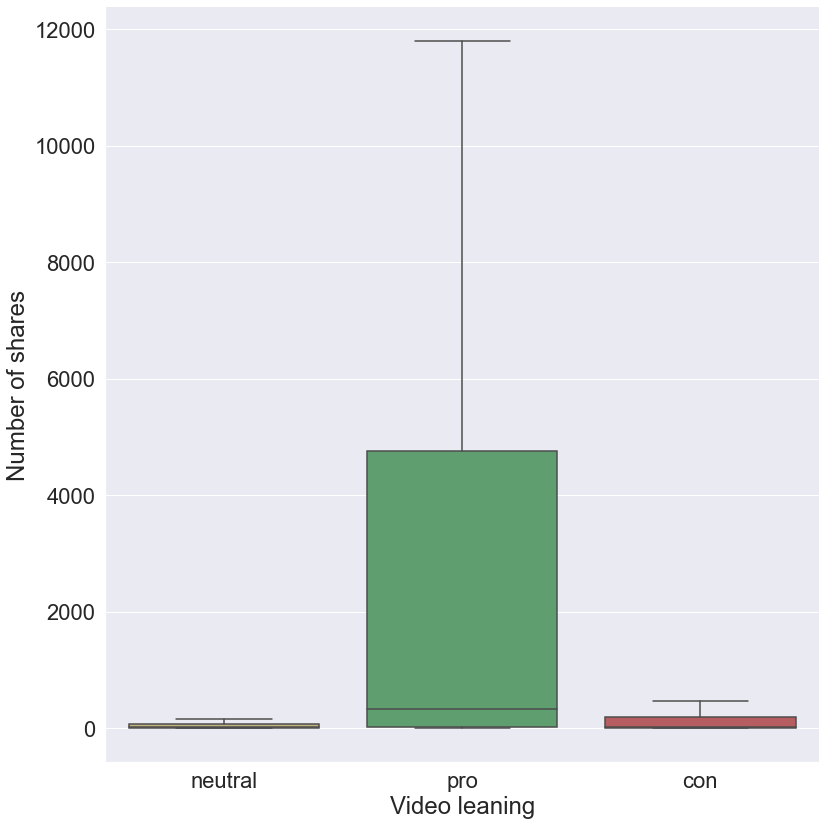

In [534]:
sns_plot = sns.catplot(x="label_new", y="stats_shares", kind="box", 
                       data=video_attributes, showfliers = False,
                       height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("Video leaning")
plt.ylabel("Number of shares")
sns_plot.savefig("video_shares_vs_labels.png")

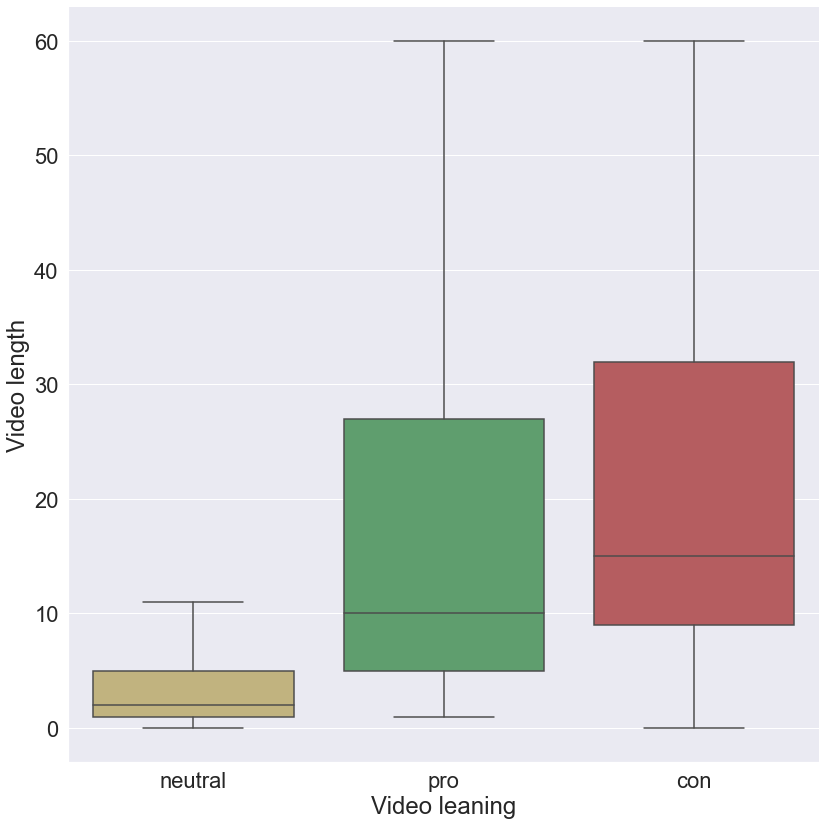

In [548]:
sns_plot = sns.catplot(x="label_new", y="video_length", kind="box", 
                       data=video_attributes, showfliers = False,
                       height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("Video leaning")
plt.ylabel("Video length")
sns_plot.savefig("video_length_vs_labels.png")

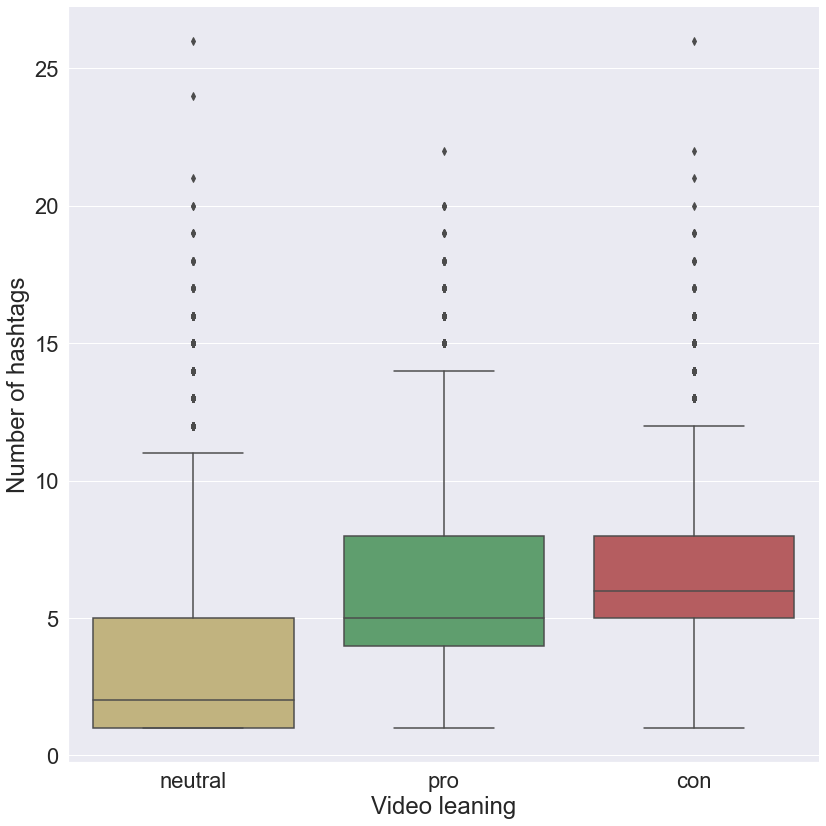

In [536]:
sns_plot = sns.catplot(x="label_new", y="nr_hashtags", kind="box", 
                       data=video_attributes, height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("Video leaning")
plt.ylabel("Number of hashtags")
sns_plot.savefig("video_numhashtags_vs_labels.png")

## Exploring user attributes

In [261]:
user_leaning_table.head()

,user_id,leaning,label,no_videos,leaning_avg,user_name,authorstats_following,authorstats_followers,authorstats_heart,authorstats_videos,authorstats_diggs,no_of_hashtags,no_of_unique_hashtags
0,73707,0.0,neutral,1,0.0,sharly_p,23.0,5990.0,720700,67.0,586.0,3,3
1,94772,3.0,pro,3,1.0,itsbriannaballard,24.0,50580.0,4700000,7.0,864.0,15,5
2,99896,0.5,pro,1,0.5,perris.howard,96.0,334800.0,7100000,198.0,1191.0,2,2
3,105232,0.5,pro,1,0.5,aarontoofresh26,28.0,480700.0,4200000,187.0,9939.0,6,6
4,117368,2.0,pro,2,1.0,troy..brown,1.0,12800.0,805000,29.0,6.0,4,2


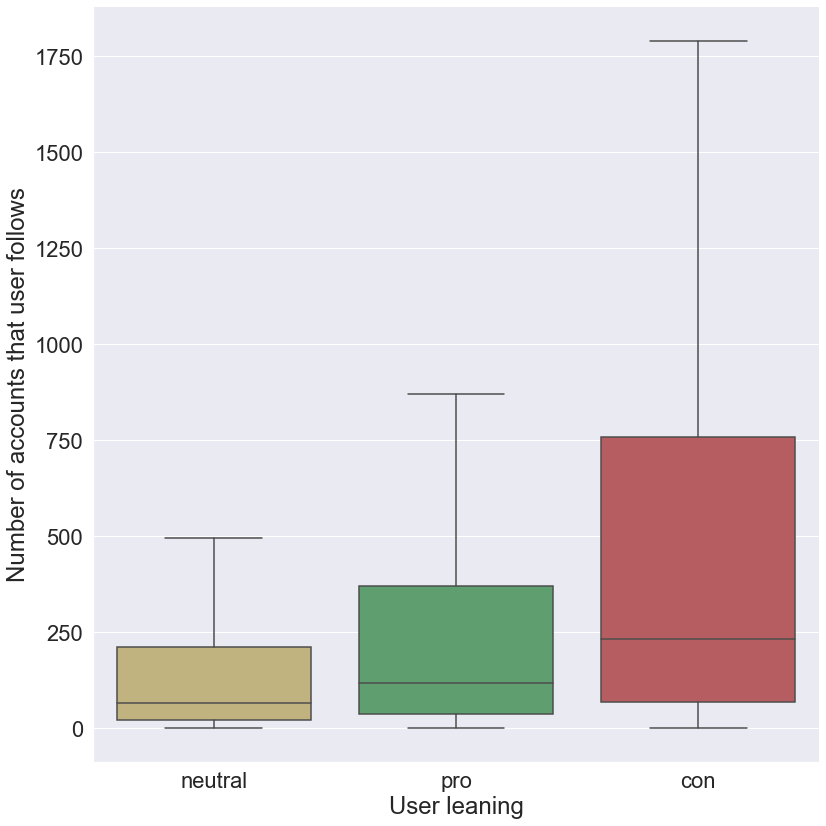

In [537]:
sns_plot = sns.catplot(x="label", y="authorstats_following", kind="box", showfliers = False, 
                       data=user_leaning_table, height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("User leaning")
plt.ylabel("Number of accounts that user follows")
sns_plot.savefig("user_following_vs_labels.png")

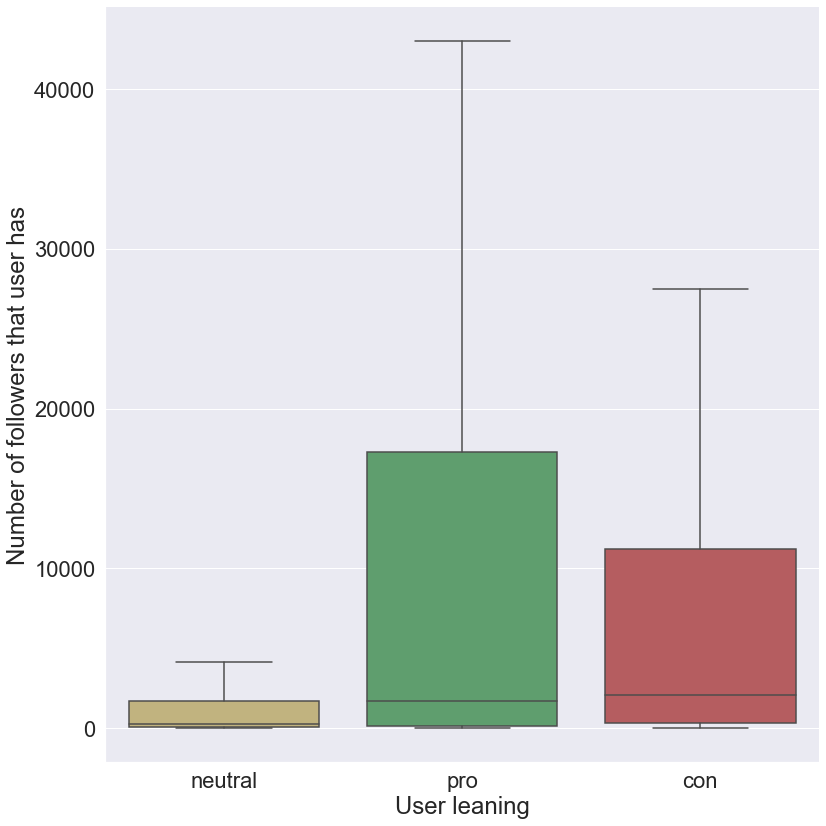

In [538]:
sns_plot = sns.catplot(x="label", y="authorstats_followers", kind="box", showfliers = False, 
                       data=user_leaning_table, height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("User leaning")
plt.ylabel("Number of followers that user has")
sns_plot.savefig("user_followers_vs_labels.png")

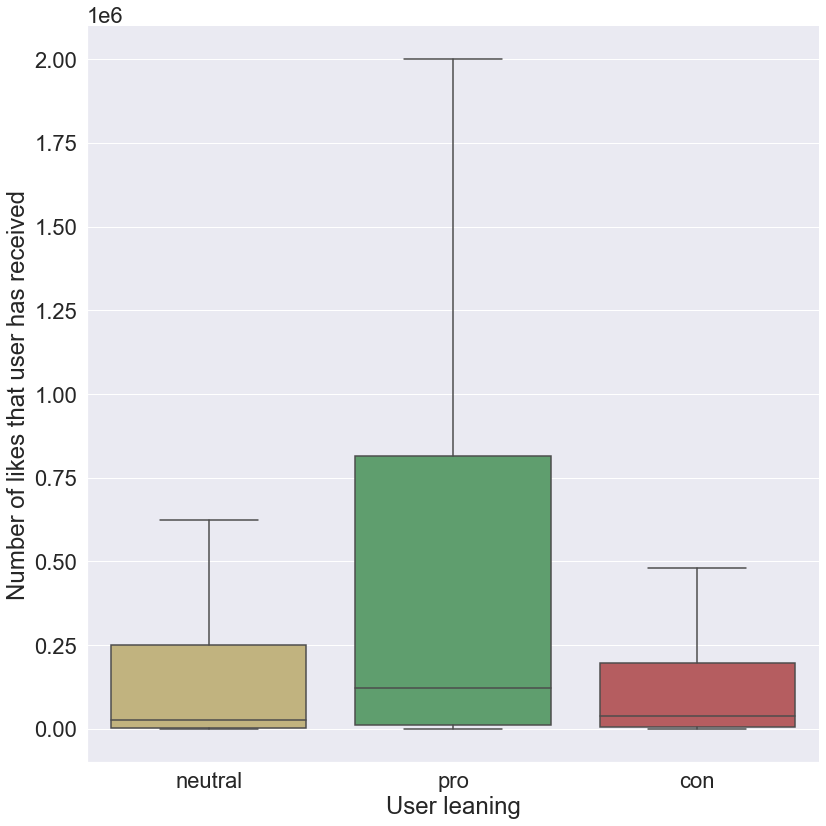

In [539]:
sns_plot = sns.catplot(x="label", y="authorstats_heart", kind="box", showfliers = False, 
                       data=user_leaning_table, height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("User leaning")
plt.ylabel("Number of likes that user has received")
sns_plot.savefig("user_hearts_vs_labels.png")

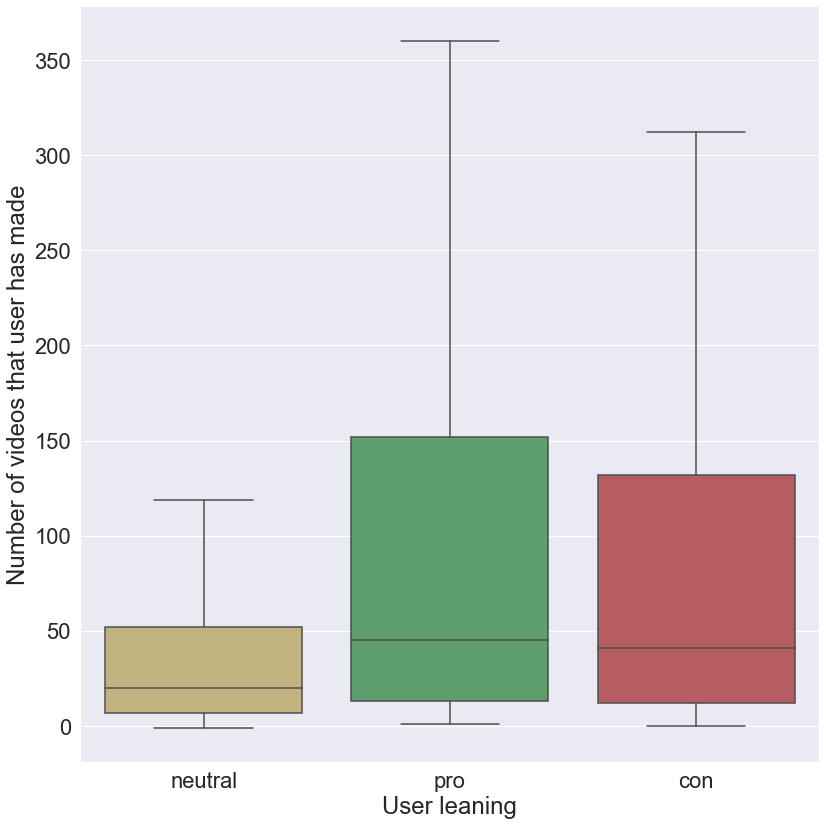

In [540]:
sns_plot = sns.catplot(x="label", y="authorstats_videos", kind="box", showfliers = False, 
                       data=user_leaning_table, height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("User leaning")
plt.ylabel("Number of videos that user has made")
sns_plot.savefig("user_videos_vs_labels.png")

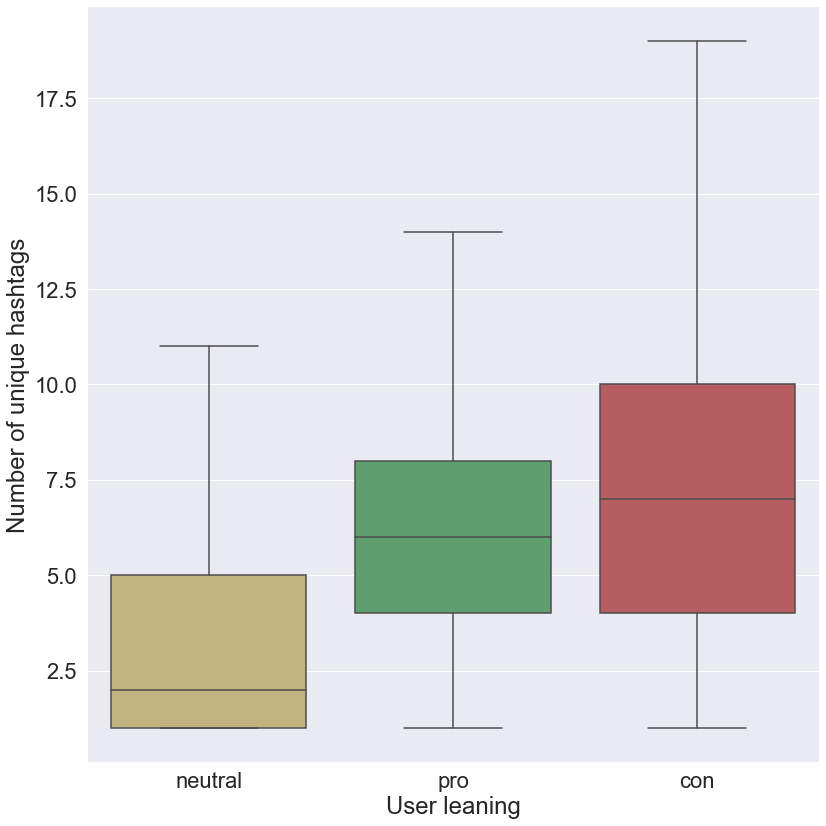

In [541]:
sns_plot = sns.catplot(x="label", y="no_of_unique_hashtags", kind="box", 
                       data=user_leaning_table, showfliers = False,
                       height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("User leaning")
plt.ylabel("Number of unique hashtags")
sns_plot.savefig("uniquehashtags_vs_labels.png")

## Video statistics

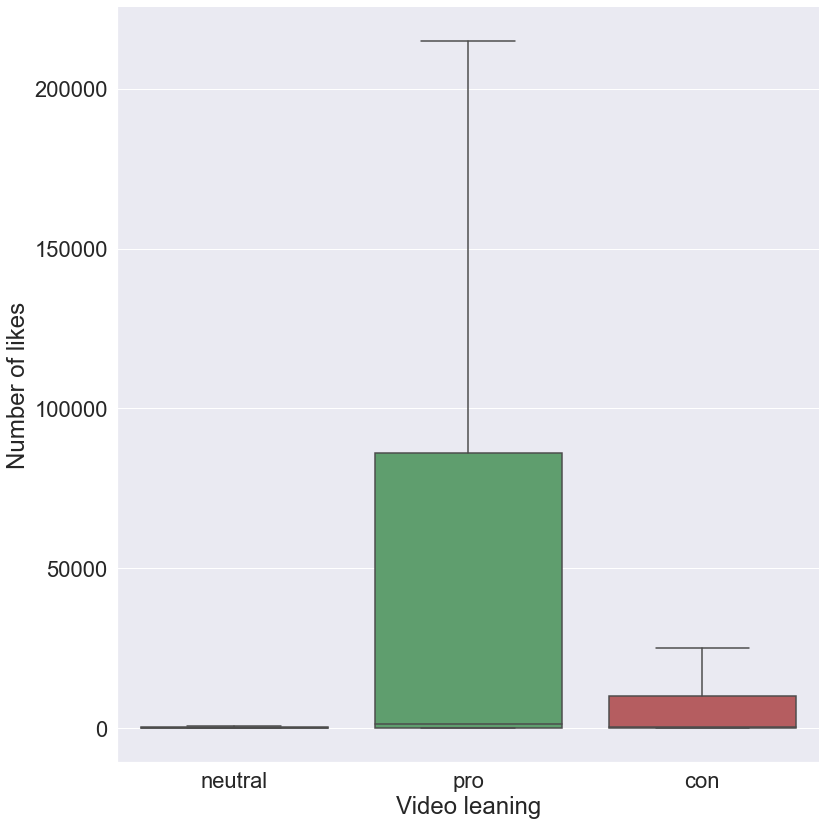

In [542]:
sns_plot = sns.catplot(x="label_new", y="stats_likes", kind="box", 
                       data=data_complete_hashtags, showfliers = False,
                       height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("Video leaning")
plt.ylabel("Number of likes")
sns_plot.savefig("videolikes_vs_label.png")

In [527]:
data_complete_hashtags.user_verified.value_counts()

False    57121
True      1025
Name: user_verified, dtype: int64

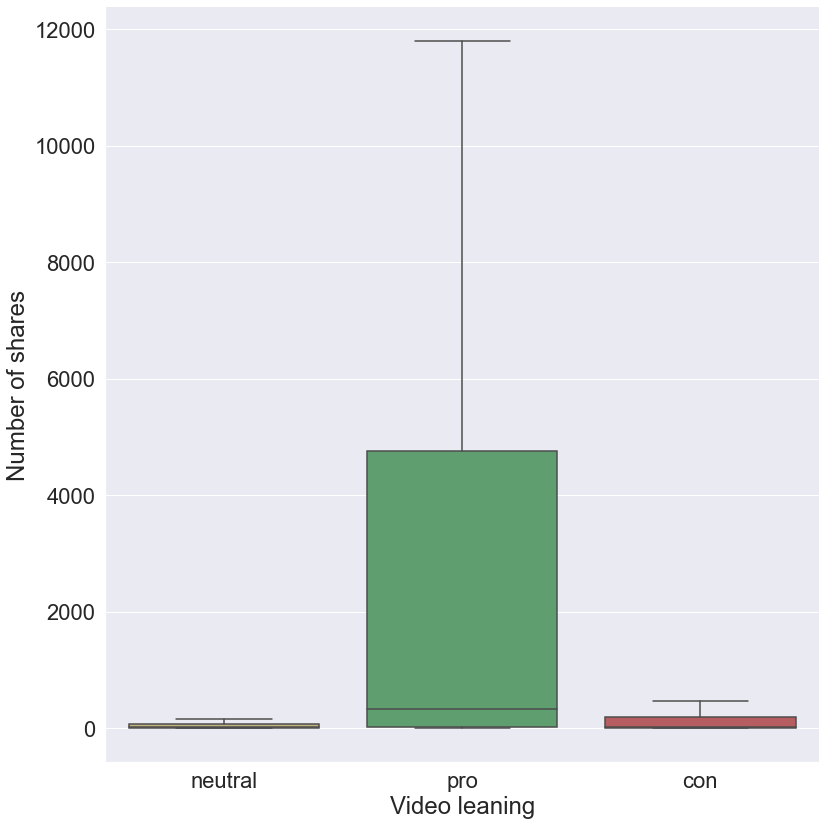

In [543]:
sns_plot = sns.catplot(x="label_new", y="stats_shares", kind="box", 
                       data=data_complete_hashtags, showfliers = False,
                       height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("Video leaning")
plt.ylabel("Number of shares")
sns_plot.savefig("videoshares_vs_label.png")

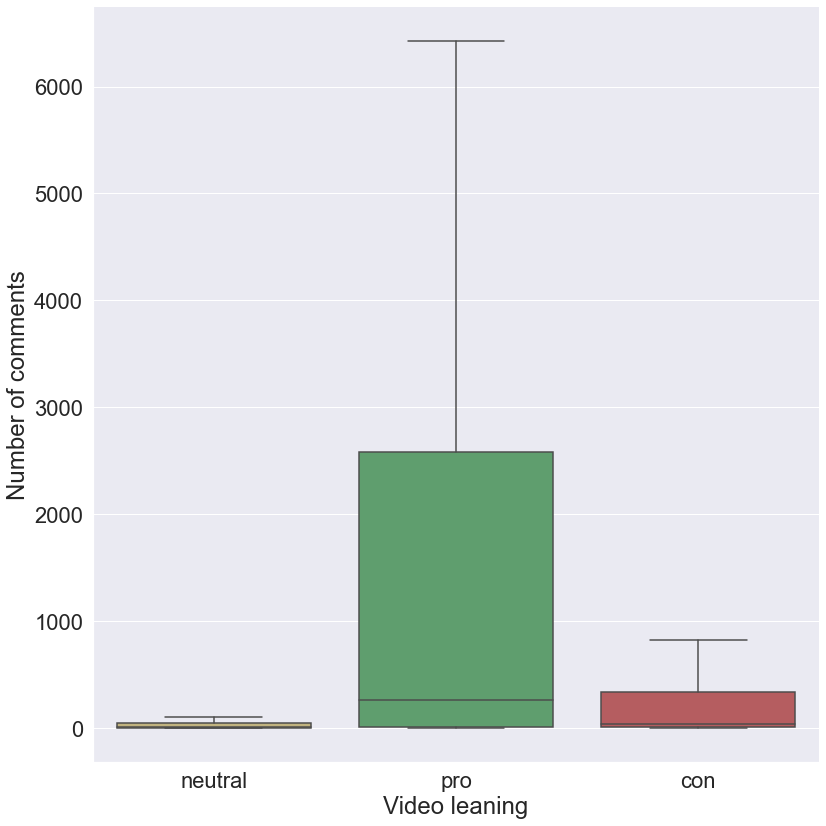

In [544]:
sns_plot = sns.catplot(x="label_new", y="stats_comments", kind="box", 
                       data=data_complete_hashtags, showfliers = False,
                       height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("Video leaning")
plt.ylabel("Number of comments")
sns_plot.savefig("videocomments_vs_label.png")

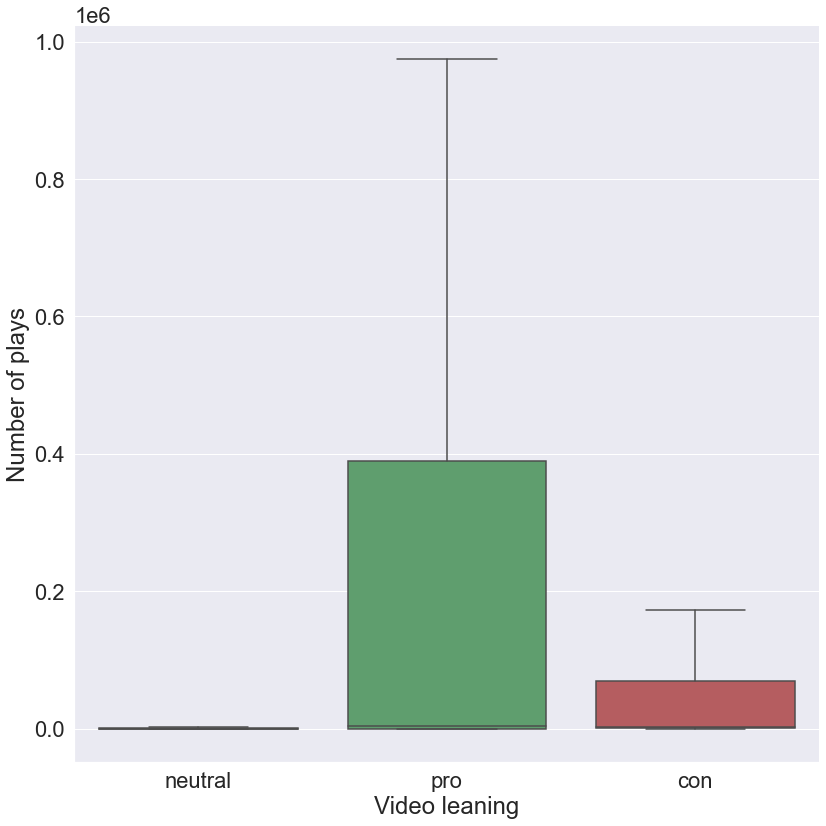

In [545]:
sns_plot = sns.catplot(x="label_new", y="stats_plays", kind="box", 
                       data=data_complete_hashtags, showfliers = False,
                       height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("Video leaning")
plt.ylabel("Number of plays")
sns_plot.savefig("videoplays_vs_label.png")

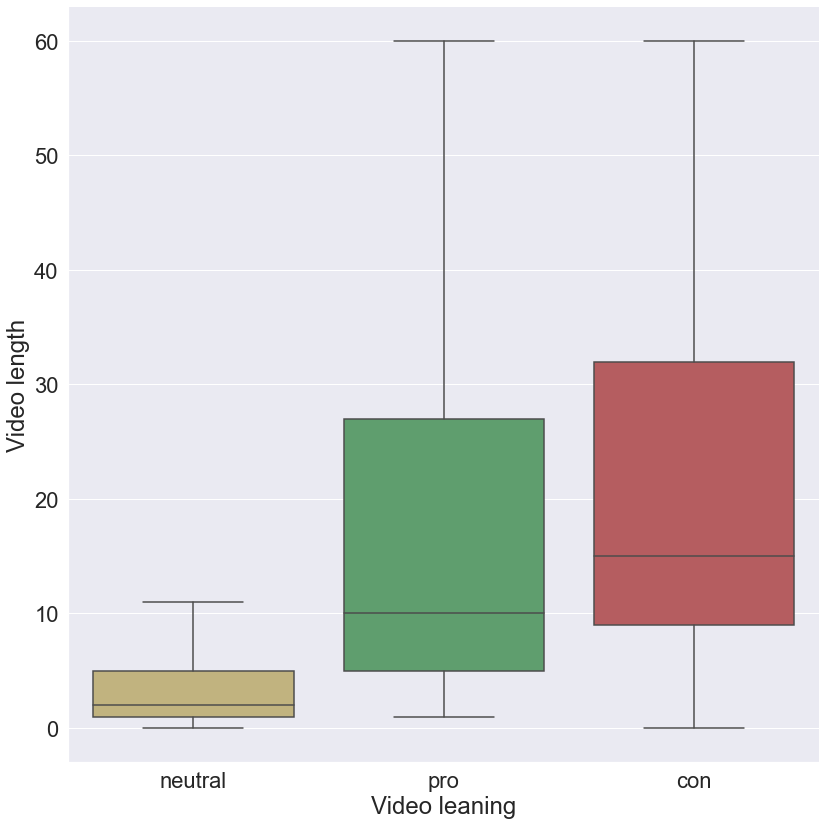

In [546]:
sns_plot = sns.catplot(x="label_new", y="video_length", kind="box", 
                       data=data_complete_hashtags, showfliers = False,
                       height = 12, palette={'pro':'g', 'con':'r', 'neutral':'y'})
plt.xlabel("Video leaning")
plt.ylabel("Video length")
sns_plot.savefig("videolength_vs_label.png")

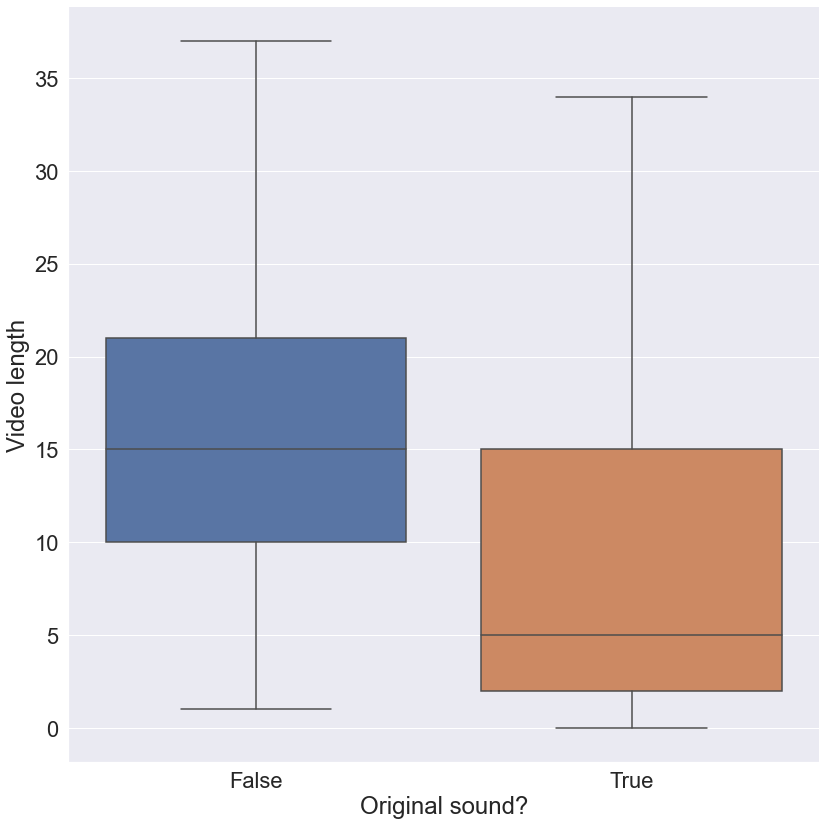

In [446]:
sns_plot = sns.catplot(x="music_original", y="video_length", kind="box", 
                       data=data_complete_hashtags, showfliers = False,
                       height = 12)
plt.xlabel("Original sound?")
plt.ylabel("Video length")
sns_plot.savefig("soundoriginal_vs_length.png")

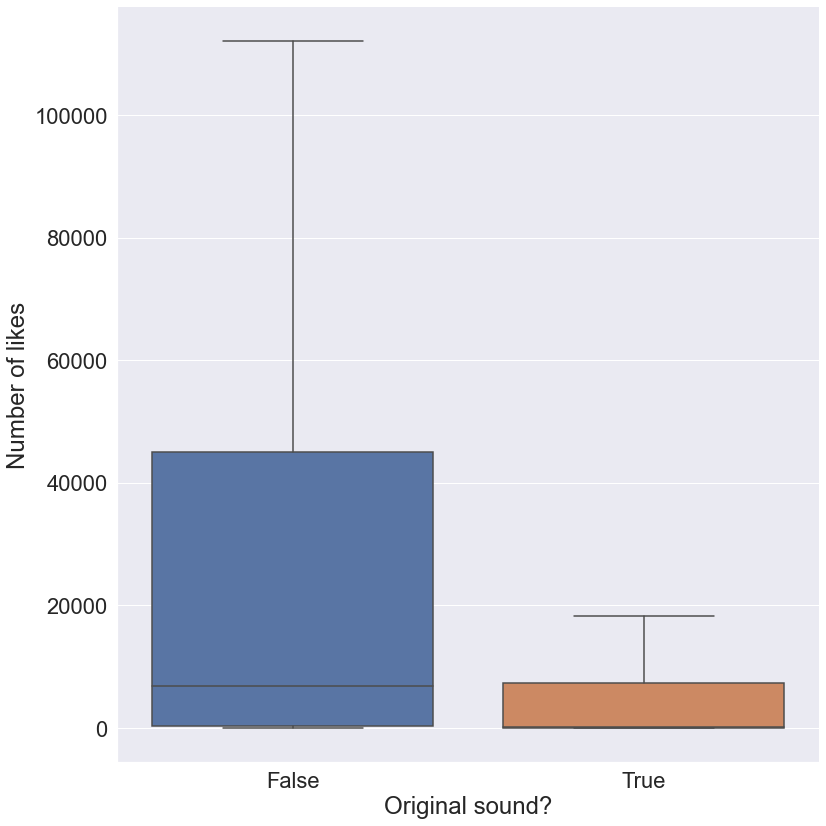

In [447]:
sns_plot = sns.catplot(x="music_original", y="stats_likes", kind="box", 
                       data=data_complete_hashtags, showfliers = False,
                       height = 12)
plt.xlabel("Original sound?")
plt.ylabel("Number of likes")
sns_plot.savefig("soundoriginal_vs_likes.png")

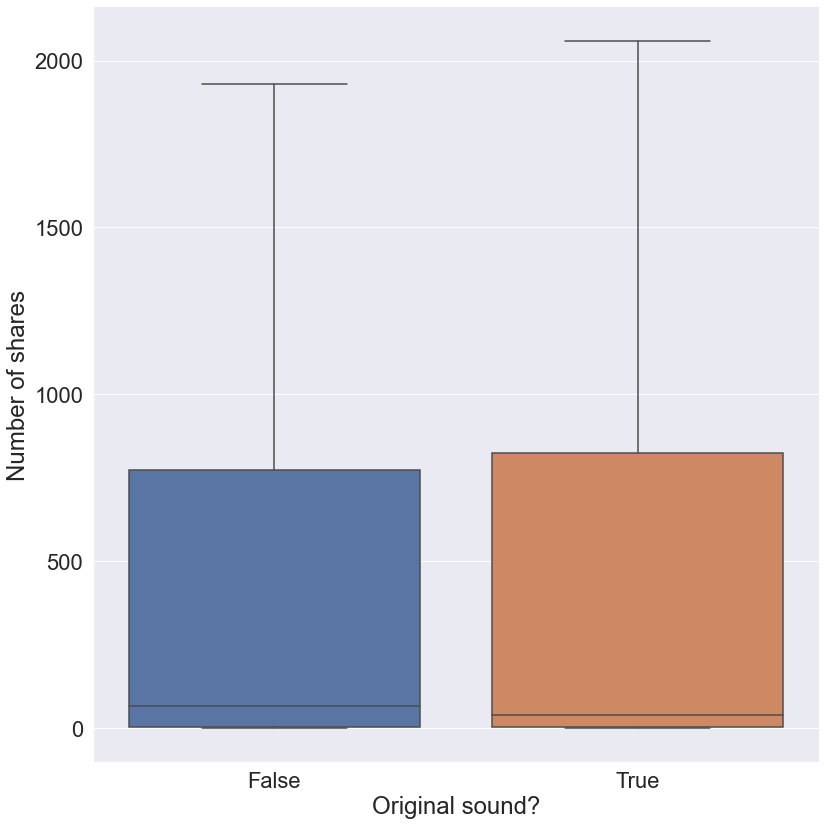

In [448]:
sns_plot = sns.catplot(x="music_original", y="stats_shares", kind="box", 
                       data=data_complete_hashtags, showfliers = False,
                       height = 12)
plt.xlabel("Original sound?")
plt.ylabel("Number of shares")
sns_plot.savefig("soundoriginal_vs_shares.png")

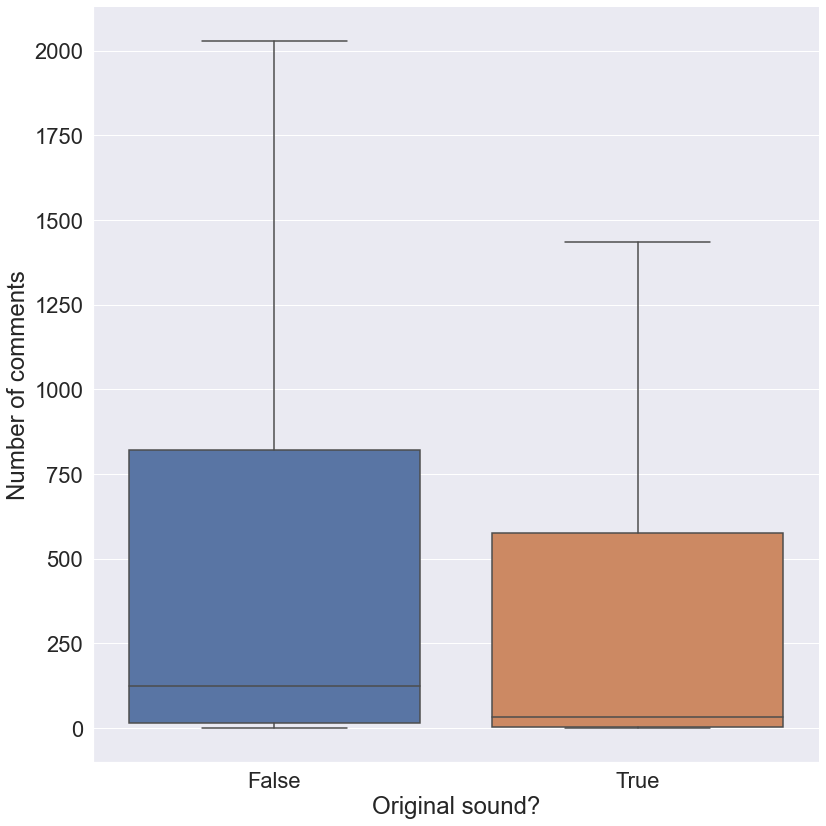

In [449]:
sns_plot = sns.catplot(x="music_original", y="stats_comments", kind="box", 
                       data=data_complete_hashtags, showfliers = False,
                       height = 12)
plt.xlabel("Original sound?")
plt.ylabel("Number of comments")
sns_plot.savefig("soundoriginal_vs_comments.png")

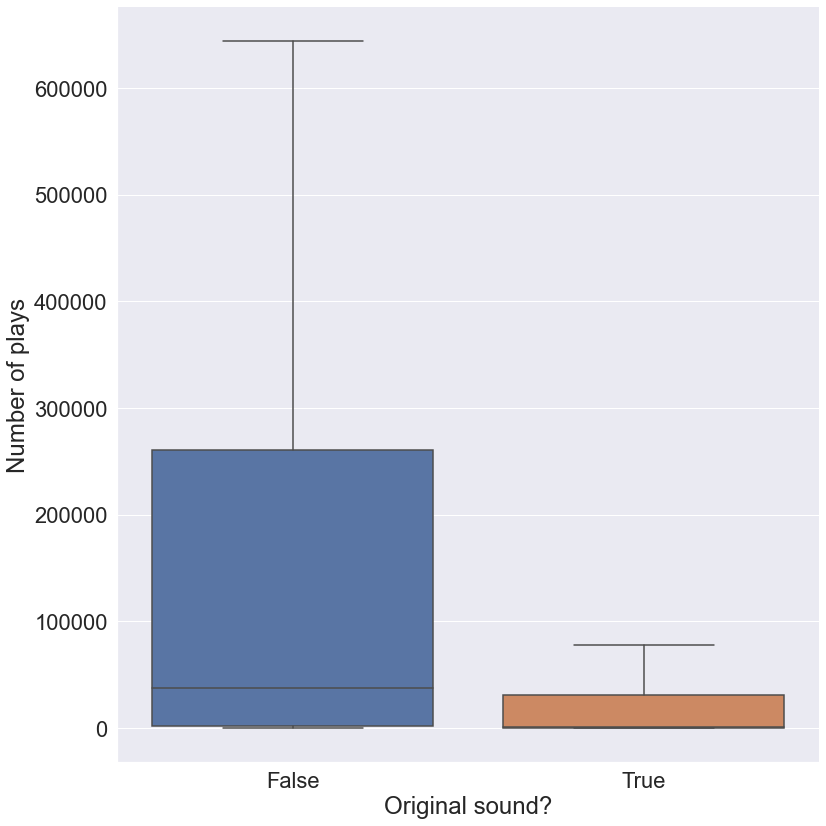

In [457]:
sns_plot = sns.catplot(x="music_original", y="stats_plays", kind="box", 
                       data=data_complete_hashtags, showfliers = False,
                       height = 12)
plt.xlabel("Original sound?")
plt.ylabel("Number of plays")
sns_plot.savefig("soundoriginal_vs_plays.png")

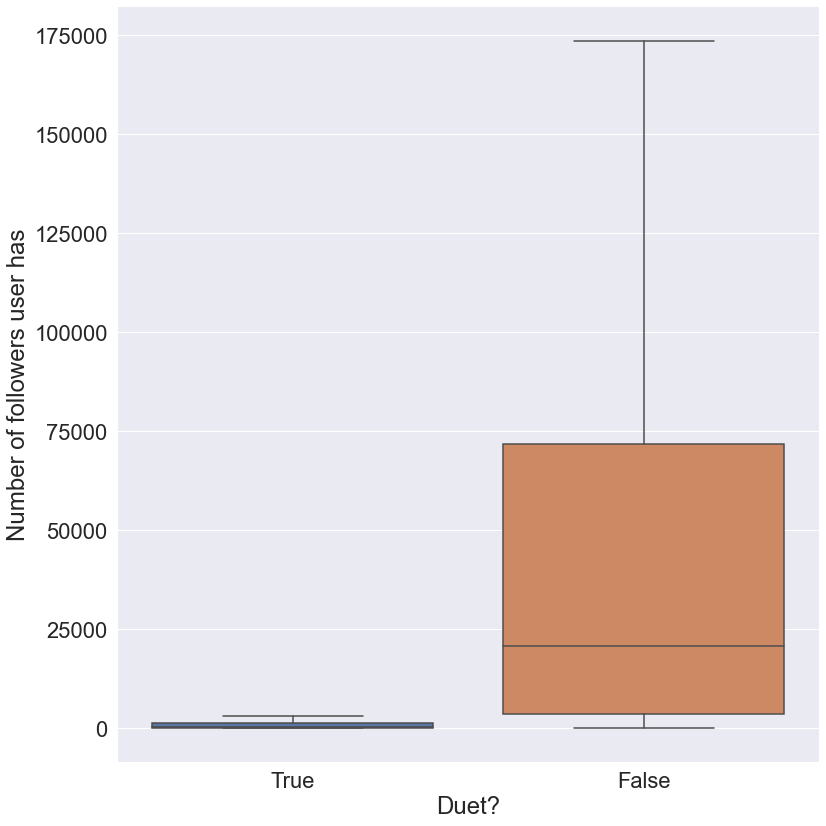

In [459]:
sns_plot = sns.catplot(x="duet_used", y="authorstats_followers", kind="box", 
                       data=data_complete_hashtags,showfliers = False,
                       height = 12)
plt.xlabel("Duet?")
plt.ylabel("Number of followers user has")
sns_plot.savefig("diet_vs_followers.png")

In [600]:
bar_plot_hash = all_hashtag_df['hashtag'].value_counts().head(20).to_frame()
bar_plot_hash.columns = ['frequency']
bar_plot_hash.index.names = ['hashtag']
bar_plot_hash.reset_index(level=0, inplace=True)

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 <a list of 7 Text major ticklabel objects>)

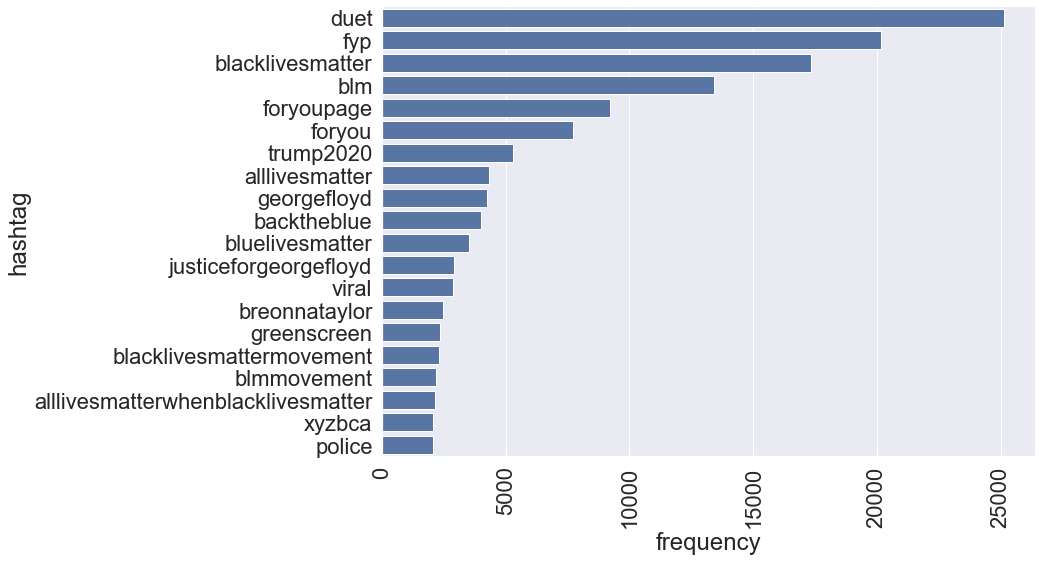

In [608]:
sns_plot = sns.barplot(y = 'hashtag', x = 'frequency', data = bar_plot_hash, color="b")
plt.xticks(rotation=90)

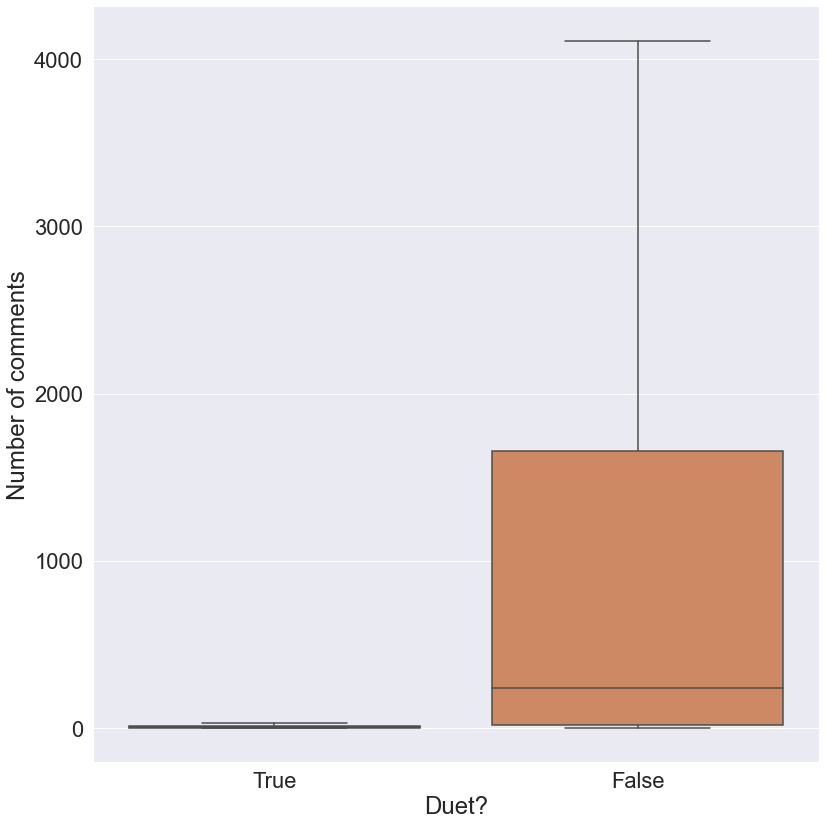

In [460]:
sns_plot = sns.catplot(x="duet_used", y="stats_comments", kind="box", 
                       data=data_complete_hashtags,showfliers = False,
                       height = 12)
plt.xlabel("Duet?")
plt.ylabel("Number of comments")
sns_plot.savefig("duet_vs_comments.png")

## Statistical testing

In [628]:
def run_mannwhitney(data1, data2, variabletested):
    # compare samples
    stat, p = mannwhitneyu(data1, data2)
    print('variable: ', variabletested)
    print('p value: ', p)
    # interpret
    alpha = 0.001

    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

In [629]:
# generate two independent samples
data1 = data_complete_hashtags[data_complete_hashtags.label_new == 'pro'].drop_duplicates(subset=['video_id']).stats_likes
data2 = data_complete_hashtags[data_complete_hashtags.label_new == 'con'].drop_duplicates(subset=['video_id']).stats_likes
run_mannwhitney(data1, data2, 'number of likes')

variable:  number of likes
p value:  3.540507912673739e-35
Different distribution (reject H0)


In [630]:
# generate two independent samples
data1 = data_complete_hashtags[data_complete_hashtags.label_new == 'pro'].drop_duplicates(subset=['video_id']).stats_shares
data2 = data_complete_hashtags[data_complete_hashtags.label_new == 'con'].drop_duplicates(subset=['video_id']).stats_shares
run_mannwhitney(data1, data2, 'number of shares')

variable:  number of shares
p value:  0.0
Different distribution (reject H0)


In [631]:
# generate two independent samples
data1 = data_complete_hashtags[data_complete_hashtags.label_new == 'pro'].drop_duplicates(subset=['video_id']).stats_comments
data2 = data_complete_hashtags[data_complete_hashtags.label_new == 'con'].drop_duplicates(subset=['video_id']).stats_comments

run_mannwhitney(data1, data2, 'number of comments')

variable:  number of comments
p value:  0.0
Different distribution (reject H0)


In [632]:
# generate two independent samples
data1 = data_complete_hashtags[data_complete_hashtags.label_new == 'pro'].drop_duplicates(subset=['video_id']).stats_plays
data2 = data_complete_hashtags[data_complete_hashtags.label_new == 'con'].drop_duplicates(subset=['video_id']).stats_plays
run_mannwhitney(data1, data2, 'number of plays')

variable:  number of plays
p value:  0.007134657175889965
Same distribution (fail to reject H0)


In [633]:
# generate two independent samples
data1 = data_complete_hashtags[data_complete_hashtags.label_new == 'pro'].drop_duplicates(subset=['video_id']).nr_hashtags
data2 = data_complete_hashtags[data_complete_hashtags.label_new == 'con'].drop_duplicates(subset=['video_id']).nr_hashtags
run_mannwhitney(data1, data2, 'number of hashtags')

variable:  number of hashtags
p value:  2.0320580438203214e-149
Different distribution (reject H0)


In [634]:
# generate two independent samples
data1 = data_complete_hashtags[data_complete_hashtags.label_new == 'pro'].drop_duplicates(subset=['video_id']).nr_tags
data2 = data_complete_hashtags[data_complete_hashtags.label_new == 'con'].drop_duplicates(subset=['video_id']).nr_tags
run_mannwhitney(data1, data2, 'number of tagged users')

variable:  number of tagged users
p value:  1.1769032206185682e-49
Different distribution (reject H0)


In [635]:
# generate two independent samples
data1 = data_complete_hashtags[data_complete_hashtags.label_new == 'pro'].drop_duplicates(subset=['video_id']).video_length
data2 = data_complete_hashtags[data_complete_hashtags.label_new == 'con'].drop_duplicates(subset=['video_id']).video_length
run_mannwhitney(data1, data2, 'video length')

variable:  video length
p value:  3.613152579776476e-151
Different distribution (reject H0)


In [636]:
# generate two independent samples
data1 = user_leaning_table[user_leaning_table.label == 'pro'].no_of_unique_hashtags
data2 = user_leaning_table[user_leaning_table.label == 'con'].no_of_unique_hashtags
run_mannwhitney(data1, data2, 'number of unique hashtags')

variable:  number of unique hashtags
p value:  1.6902844884317913e-76
Different distribution (reject H0)


In [637]:
# generate two independent samples
data1 = user_leaning_table[user_leaning_table.label == 'pro'].authorstats_followers
data2 = user_leaning_table[user_leaning_table.label == 'con'].authorstats_followers
run_mannwhitney(data1, data2, 'number of followers')

variable:  number of followers
p value:  0.009337944594609883
Same distribution (fail to reject H0)


In [638]:
# generate two independent samples
data1 = user_leaning_table[user_leaning_table.label == 'pro'].authorstats_following
data2 = user_leaning_table[user_leaning_table.label == 'con'].authorstats_following
run_mannwhitney(data1, data2, 'number of people followed')

variable:  number of people followed
p value:  1.0518179104098693e-118
Different distribution (reject H0)


## Interaction structure

In [492]:
who_duetted_with_whom_cooc.head()

,user_id,tagged_id,co_occurences,user_label,tagged_label,link_label
0,154547,6724511517688071174,1,pro,pro,agree
1,370496,6724511517688071174,1,pro,pro,agree
2,3731242,6724511517688071174,1,pro,pro,agree
3,4485058,6724511517688071174,1,pro,pro,agree
4,4855799,6724511517688071174,1,pro,pro,agree


In [493]:
who_duetted_with_whom_cooc.shape[0]

20292

In [501]:
pro_con = who_duetted_with_whom_cooc[(who_duetted_with_whom_cooc.user_label == 'pro') & (who_duetted_with_whom_cooc.tagged_label == 'con')].shape[0]
pro_con

155

In [502]:
pro_pro = who_duetted_with_whom_cooc[(who_duetted_with_whom_cooc.user_label == 'pro') & (who_duetted_with_whom_cooc.tagged_label == 'pro')].shape[0]
pro_pro

5712

In [504]:
pro_neutral = who_duetted_with_whom_cooc[(who_duetted_with_whom_cooc.user_label == 'pro') & (who_duetted_with_whom_cooc.tagged_label == 'neutral')].shape[0]
pro_neutral

1002

In [505]:
con_pro = who_duetted_with_whom_cooc[(who_duetted_with_whom_cooc.user_label == 'con') & (who_duetted_with_whom_cooc.tagged_label == 'pro')].shape[0]
con_pro

442

In [506]:
con_con = who_duetted_with_whom_cooc[(who_duetted_with_whom_cooc.user_label == 'con') & (who_duetted_with_whom_cooc.tagged_label == 'con')].shape[0]
con_con

660

In [507]:
con_neutral = who_duetted_with_whom_cooc[(who_duetted_with_whom_cooc.user_label == 'con') & (who_duetted_with_whom_cooc.tagged_label == 'neutral')].shape[0]
con_neutral

318

In [509]:
pro_total = who_duetted_with_whom_cooc[(who_duetted_with_whom_cooc.user_label == 'pro')].shape[0]
pro_total

6869

In [510]:
con_total = who_duetted_with_whom_cooc[(who_duetted_with_whom_cooc.user_label == 'con')].shape[0]
con_total

1420

In [511]:
pro_pro/pro_total

0.8315620905517542

In [512]:
pro_con/pro_total

0.022565147765322462

In [513]:
pro_neutral/pro_total

0.1458727616829233

In [514]:
con_con/con_total

0.4647887323943662

In [515]:
con_pro/con_total

0.3112676056338028

In [516]:
con_neutral/con_total

0.223943661971831